# Problema de Negócio

Uma empresa de seguro, onde seus clientes utilizam seguro de saúde gostaria de saber se esses clientes comprariam um novo produto, um seguro de automóvel. Para sanar essa dúvida foi desenvolvida uma pesquisa que trouxe as informações sobre o cliente e quais consumidores comprariam e quais não comprariam o produto.

Existem novos clientes que não participaram da pesquisa e a empresa precisa saber se comprariam o seguro de automóvel ou não, para poderem direcionar seu time de vendas para os clientes interessados.

Para a venda do novo seguro foi criada uma campanha por telefone, e o limite de ligações será de 20000. O produto desenvolvido será um classificador que crie um rank identificando os clientes mais propensos a adquirir o novo produto.



# 0.0 Import Libraries, Load Data and auxiliar functions

In [1]:
import json
import pickle
import random
import sklearn
import inflection
import numpy             as np
import pandas            as pd 
import seaborn           as sns 
# import scikitplot        as skplt

import scipy.stats       as stats
import matplotlib.pyplot as plt

from IPython.display         import Image
from boruta                  import BorutaPy

from sklearn.pipeline          import Pipeline
from sklearn                   import metrics as mt
from sklearn.compose           import ColumnTransformer
from sklearn                   import model_selection as ms
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection   import cross_val_score, StratifiedKFold
from sklearn.metrics           import roc_curve, auc, make_scorer, precision_score, recall_score
from sklearn.preprocessing     import MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.tree            import DecisionTreeClassifier, plot_tree




In [100]:
# Paleta de cores utilizada
custom_palette = ['#003366', '#006400', '#800020', '#3E2723']
sns.set_palette(custom_palette)
sns.color_palette(custom_palette)

[(0.0, 0.2, 0.4),
 (0.0, 0.39215686274509803, 0.0),
 (0.5019607843137255, 0.0, 0.12549019607843137),
 (0.24313725490196078, 0.15294117647058825, 0.13725490196078433)]

In [3]:
df_raw = pd.read_csv('../data/train.csv')
# df_test = pd.read_csv('../data/test.csv')

## 0.1 Separação de dados em Treino, Teste e Validação

In [4]:
df1 = df_raw.copy()

dfx = df1.drop(columns=['Response'])
dfy = df1['Response']

# Utilizei Estratificação para manter a mesma proporção entre as categorias durante o split
dfx_train, dfx_test, dfy_train, dfy_test =  ms.train_test_split(dfx, dfy, test_size = 0.2, stratify=dfy, random_state = 12)

df1 = pd.concat([dfx_train, dfy_train], axis=1)
print(dfy_train.value_counts())
print(dfy_test.value_counts())

df_test_prod = pd.concat([dfx_test, dfy_test], axis=1)
df_test_prod.to_csv('../data/test_prod.csv')

Response
0    267519
1     37368
Name: count, dtype: int64
Response
0    66880
1     9342
Name: count, dtype: int64


## 0.2 Funções auxiliares 

In [5]:
# Função para calcular o coeficiente de Cramér's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))

In [6]:
from auxiliar_functions import cross_validation_pipeline, curva_ganho, params_tuning
from auxiliar_functions import precision_top_k, preparation_train, preparation_val, recall_top_k

# 1.0 Data Description

## 1.1 Significado das colunas 

| Variable              | Definition                                                                                 |
|-----------------------|---------------------------------------------------------------------------------------------|
| `id`                 | Unique ID for the customer                                                                 |
| `Gender`             | Gender of the customer                                                                     |
| `Age`                | Age of the customer                                                                        |
| `Driving_License`    | 0: Customer does not have DL, 1: Customer already has DL                                    |
| `Region_Code`        | Unique code for the region of the customer                                                 |
| `Previously_Insured` | 1: Customer already has Vehicle Insurance, 0: Customer doesn't have Vehicle Insurance       |
| `Vehicle_Age`        | Age of the Vehicle                                                                         |
| `Vehicle_Damage`     | 1: Customer got his/her vehicle damaged in the past. 0: Customer didn't get his/her vehicle damaged in the past |
| `Annual_Premium`     | The amount customer needs to pay as premium in the year                                    |
| `Policy_Sales_Channel` | Anonymized Code for the channel of outreaching to the customer, e.g., Different Agents, Over Mail, Over Phone, In Person, etc. |
| `Vintage`            | Number of days the customer has been associated with the company                           |
| `Response`           | 1: Customer is interested, 0: Customer is not interested                                   |

## 1.2 Tipos de dados, tamanho do dataset e verificação de nulos 

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304887 entries, 336707 to 83271
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304887 non-null  int64  
 1   Gender                304887 non-null  object 
 2   Age                   304887 non-null  int64  
 3   Driving_License       304887 non-null  int64  
 4   Region_Code           304887 non-null  float64
 5   Previously_Insured    304887 non-null  int64  
 6   Vehicle_Age           304887 non-null  object 
 7   Vehicle_Damage        304887 non-null  object 
 8   Annual_Premium        304887 non-null  float64
 9   Policy_Sales_Channel  304887 non-null  float64
 10  Vintage               304887 non-null  int64  
 11  Response              304887 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 30.2+ MB


Dataset não possui valores nulos, reduzindo trabalho de limpeza
  

In [8]:
print(f'Colunas: {df1.shape[1]}')
print(f'Linhas: {df1.shape[0]}')

Colunas: 12
Linhas: 304887


## 1.3 Renomeando colunas

In [9]:
cols = list(df1.columns)
lista = [inflection.underscore(coluna) for coluna in cols ]
df1.columns = lista
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.4 Estatística descritiva

In [10]:
df1.head(3)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
336707,336708,Female,23,1,30.0,1,< 1 Year,No,21620.0,152.0,138,0
193582,193583,Male,58,1,3.0,0,1-2 Year,Yes,2630.0,26.0,197,0
170385,170386,Female,24,1,28.0,0,< 1 Year,Yes,47596.0,152.0,53,0


In [11]:
# df_number = df1.select_dtypes(include = ['int64', 'float64'])
df_number = df1[['age', 'region_code','annual_premium',
                 'policy_sales_channel', 'vintage']].copy()

# df_object = df1.select_dtypes(include = ['object'])
df_object = df1[['gender', 'vehicle_age', 'vehicle_damage', 'driving_license',
                 'previously_insured', 'response']].copy()

### 1.4.1 Atributos numéricos

In [12]:
df_number.describe().T

,count,mean,std,min,25%,50%,75%,max
age,304887.0,38.812176,15.514660,20.0,25.0,36.0,49.0,85.0
region_code,304887.0,26.392729,13.233277,0.0,15.0,28.0,35.0,52.0
annual_premium,304887.0,30576.530875,17249.118702,2630.0,24397.0,31673.0,39423.0,540165.0
policy_sales_channel,304887.0,112.124909,54.167967,1.0,29.0,136.0,152.0,163.0
vintage,304887.0,154.294306,83.627240,10.0,82.0,154.0,227.0,299.0


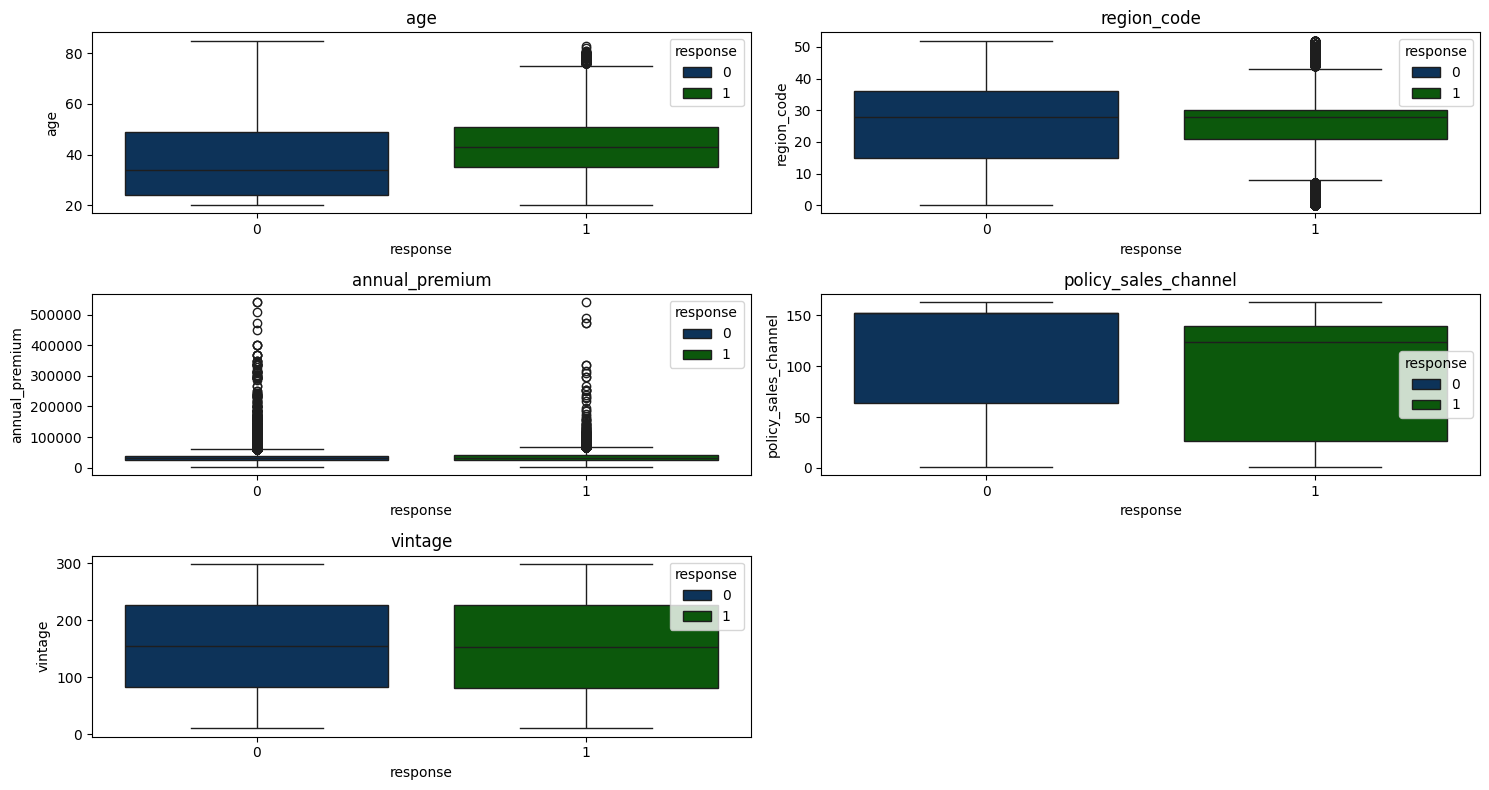

In [13]:
plt.figure(figsize=(15, 8))
for n, coluna in enumerate(df_number.columns, start=1):
    plt.subplot(3, 2, n)
    sns.boxplot(data=df1, x='response', y=coluna, hue= 'response')
    plt.title(coluna)
    plt.tight_layout()


-  'annual_premium' possui uma grande quantidade de outliers, como não possuo conhecimento aprofundado do negócio não posso afirmar se são informativos ou não

### 1.4.2 Atributos Categóricos 

In [14]:
df_object.apply(lambda x: x.unique())

gender                                 [Female, Male]
vehicle_age           [< 1 Year, 1-2 Year, > 2 Years]
vehicle_damage                              [No, Yes]
driving_license                                [1, 0]
previously_insured                             [1, 0]
response                                       [0, 1]
dtype: object

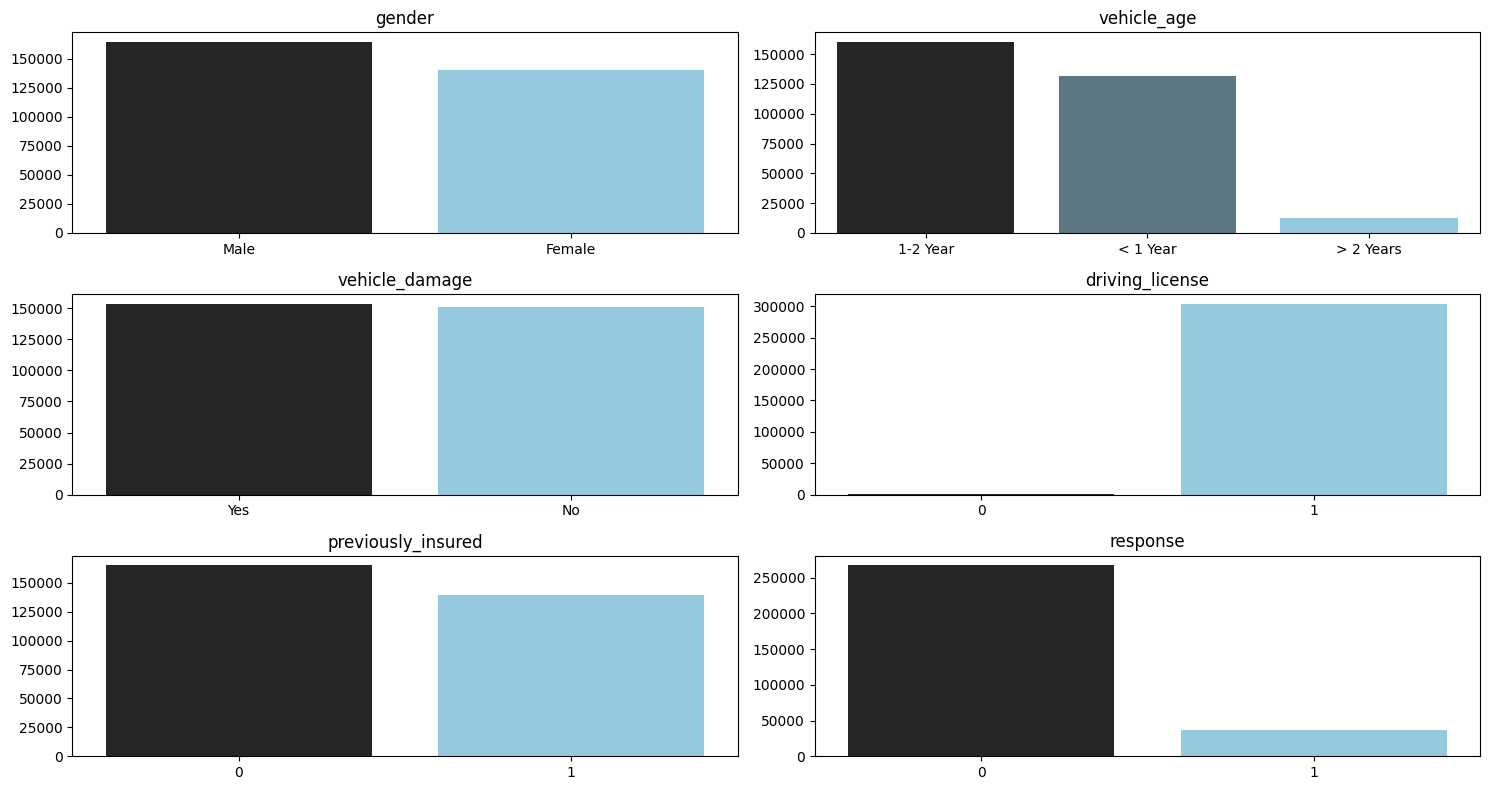

In [15]:
plt.figure(figsize=(15, 8))

for n, coluna in enumerate(df_object.columns, start=1):
    counts = df_object[coluna].value_counts()
    plt.subplot(3, 2, n) 
    sns.barplot( x=counts.index, y=counts.values, hue = counts.index,palette='dark:skyblue')
    plt.xlabel('')
    plt.title(coluna)
    plt.legend([], frameon=False)
    plt.tight_layout()
    

#  2.0 Feature Engeneering

## 2.0.1 Negócio

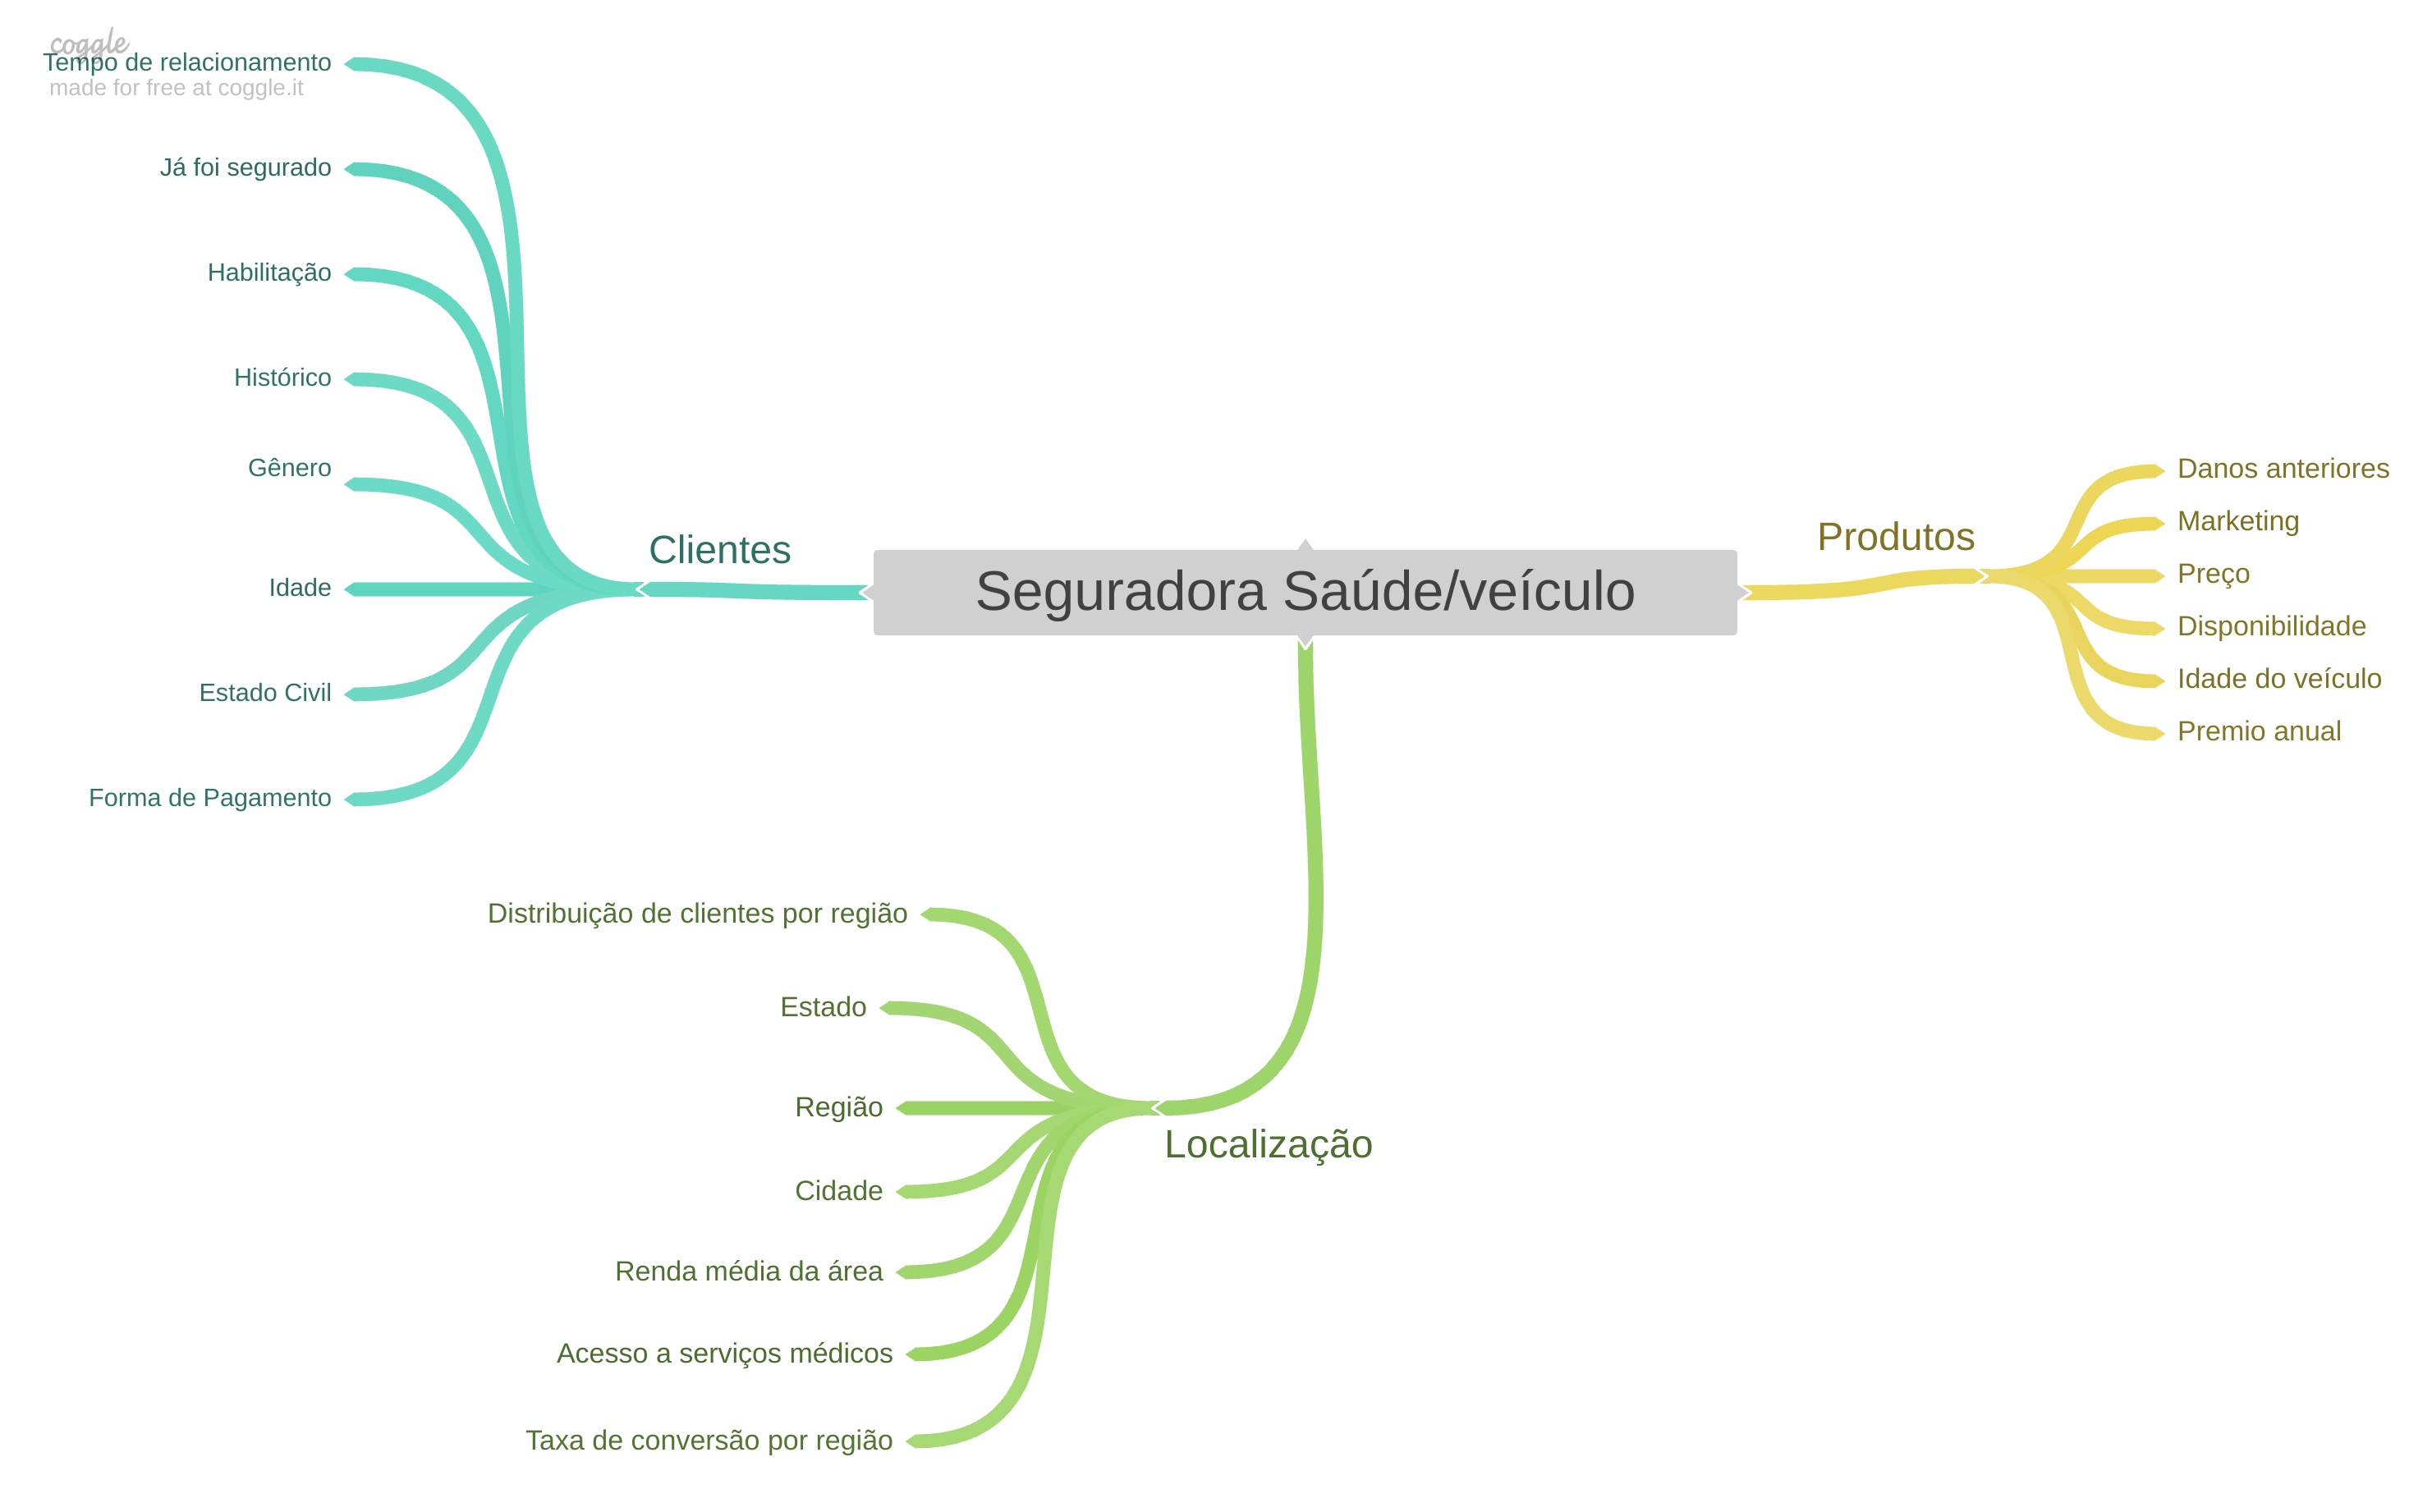

In [16]:
Image('../img/img_seguradora.png')

## 2.1 Criação das Hipóteses

### 2.1.1 Hipóteses para Clientes

1. Clientes mais experientes (>=30 anos) têm maior propensão a contratar seguros para veículos pelo desejo de segurança.  

2. Clientes que já tiveram seguro anteriormente tem maior interesse em contratar o seguro.
3. Mulheres tem uma propenção maior para contratar seguros.
4. Clientes casados ou com filhos tendem a contratar seguros mais robustos devido à necessidade de proteção familiar.
5. Clientes com habilitação recente apresentam maior risco e, consequentemente, optam por planos básicos devido ao custo.


### 2.1.2 Hipóteses para Produtos

1. Clientes com veículos entre 1 e 2 anos são mais comumentes interessados no seguro.

2. Planos com preços acessíveis e benefícios extras, como assistência 24 horas, têm maior taxa de conversão.
3. Pessoas que já sofreram danos em veículos tem maior interesse em contratar o seguro.
4. A inclusão de seguros específicos para veículos elétricos ou híbridos pode atrair clientes com maior poder aquisitivo.
5. Pessoas que já tiveram seguro anteriormente tem maior interesse em contratar o seguro.


### 2.1.3 Hipóteses para Localização

1. Regiões com maior índice de roubos e furtos têm maior demanda por seguros com cobertura contra roubo.

2. Clientes em áreas urbanas têm maior adesão a seguros devido à maior exposição a acidentes.
3. Regiões com renda média mais alta têm maior interesse em seguros premium, com coberturas completas.
4. Cidades com menor acesso a serviços médicos ou oficinas têm maior interesse em seguros com benefícios de assistência em viagens.
5. Áreas com alto índice de acidentes de trânsito têm maior conversão em seguros com coberturas de danos a terceiros.

## 2.2 Top 8 Hipóteses  

1. Clientes mais experientes (>=30 anos) têm maior propensão a contratar seguros para veículos por procurar segurança.  

2. Clientes que já possuem um histórico de seguro têm maior probabilidade de se interessar pelo seguro. 

3. Mulheres tem maior propenção para contratar seguros, priorizando segurança.  

4. Clientes que já sofreram danos em veículos no passado têm maior chance de contratar seguros. 

5. Planos com preços mais acessíveis atraem clientes jovens ou com menor histórico de seguro. 

6. Clientes com mais ano de casa tem maior propenção de desejar o novo produto . 

7. Clientes com veículos mais novos são mais comumentes interessados no seguro. 

8. Clientes em regiões onde há maior proporção de veículos danificados têm maior probabilidade de contratar seguros.


## 2.3 Feature Engeneering

In [17]:
df2 = df1.copy()
df2.head(2)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
336707,336708,Female,23,1,30.0,1,< 1 Year,No,21620.0,152.0,138,0
193582,193583,Male,58,1,3.0,0,1-2 Year,Yes,2630.0,26.0,197,0


In [18]:
df2 = df1.copy()

# Separando clientes por custo do prêmio (categoria)
df2['premium_category'] = pd.cut(df2['annual_premium'],
                                 bins=[0, 10000, 30000, 50000, np.inf],
                                 labels=['Baixo\n(0:10000)', 'Médio\n(10000:30000)', 'Alto\n(30000:50000)', 'Muito Alto\n(50000:)'])

# Separando grupos de clientes de acordo com o tempo de 'vintage' (dias)
df2['vintage_group'] = pd.cut(df2['vintage'], bins=[0, 60, 120, 240, np.inf], labels=['Recente\n(0:60)dias', 'Intermediário\n(60:120)', 'Longo\n(120:240)', 'Muito Longo\n(240:)'])

# Criando coluna com a porcentagem de veículos danificados na região do cliente
damage = df2.loc[df2['vehicle_damage']=='Yes',['id','region_code']].groupby('region_code').agg({'id':'count'})
total = pd.DataFrame(df2.groupby(['region_code'])['id'].count())
merged = damage.merge(total, on= 'region_code')
merged.columns = ['veiculos_danificados_regiao', 'total_veiculos_regiao']
merged['pct_damage_region'] = ((merged['veiculos_danificados_regiao']/merged['total_veiculos_regiao'])*100).astype(int)

df2 = pd.merge(df2, merged, on= 'region_code', how='left') 


# 3.0 - EDA (Análise Exploratória de Dados)

## 3.1 Análise Univariada

### 3.1.1 Variavel Responsta

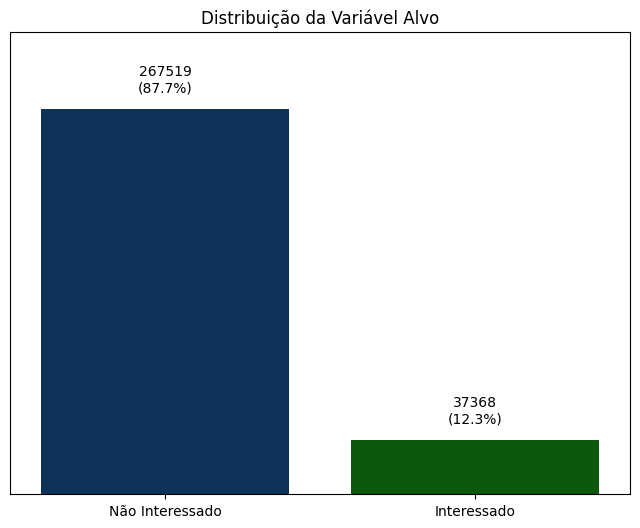

In [19]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df1, x='response', hue='response', dodge=False)

ax.legend([], [], frameon=False)
ax.yaxis.set_visible(False)

plt.xticks(ticks=[0, 1], labels=['Não Interessado', 'Interessado'])
plt.xlabel('')
plt.title('Distribuição da Variável Alvo')

plt.ylim(0, df1['response'].value_counts().max() * 1.2)

total = len(df1)
category_counts = df1['response'].value_counts()

for index, category in enumerate(category_counts.index):
    count = category_counts[category] 
    percentage = 100 * count / total 
    x = index 
    y = count +10000
    ax.text(x, y, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.show()


- Como há um desbalanceamento de classes e o objetívo é encontrar os clientes com a maior propensão de compra utilizarei a métrica Precision para identificar os acertos na classe de interesse.

### 3.1.2 Distribuições das Variáveis Numéricas

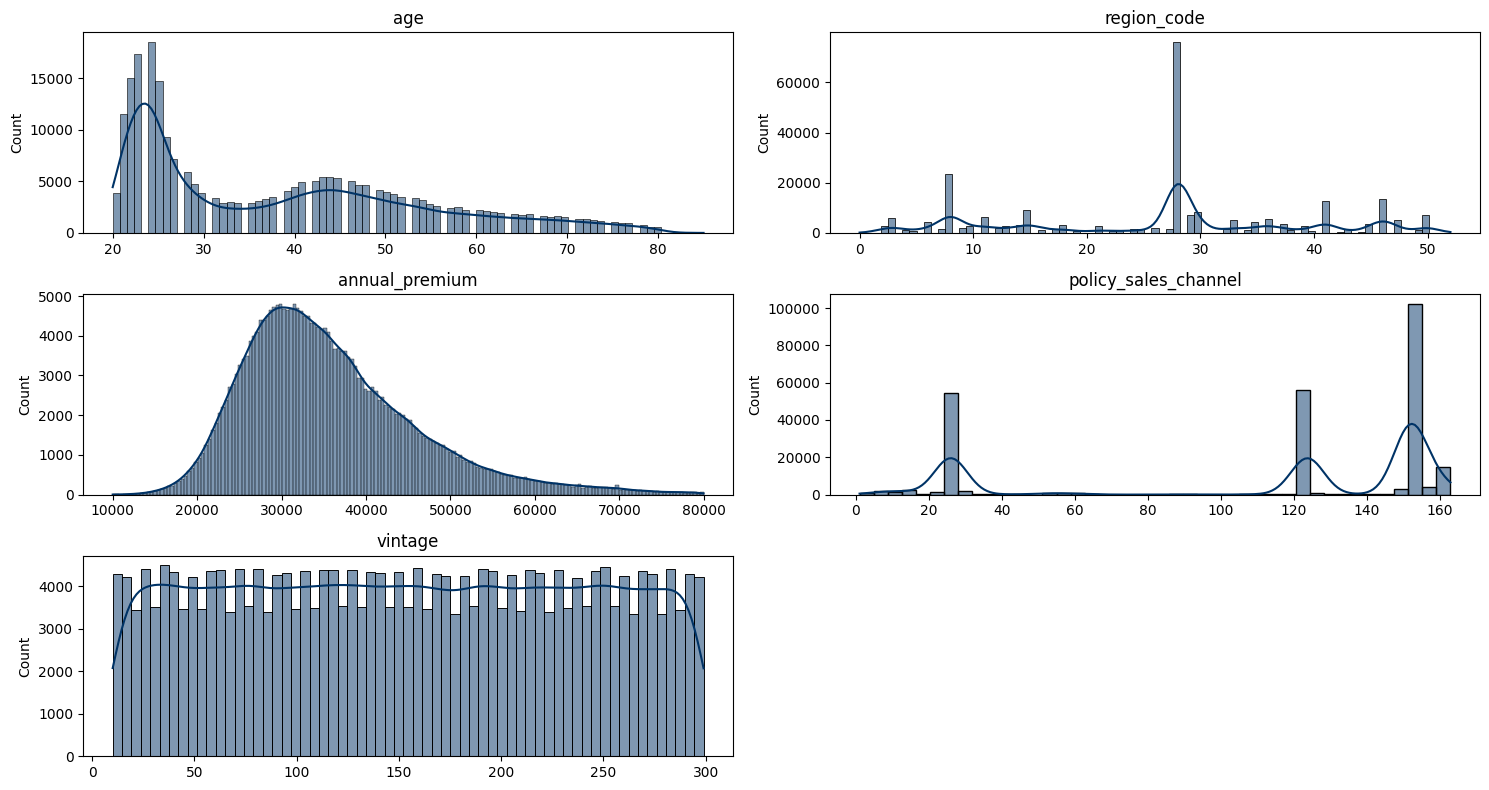

In [20]:
# retirando os outliers para entender melhor a distribuição de 'annual_premium'
aux = df_number[(df_number['annual_premium']>10000) & (df_number['annual_premium']<80000)] 
# aux=df_number.copy(
plt.figure(figsize=(15, 8))
for n, coluna in enumerate(df_number.columns, start=1):
    plt.subplot(3, 2, n)  
    sns.histplot(data=aux, x=coluna, kde=True)
    plt.title(coluna)
    plt.xlabel('')
    plt.tight_layout()


- A distribuição de 'age' está mais concentrada em jovens de 20 a 25 anos, é uma ótima oportunidade de gerar uma relação duradoura e lucrativa com o cliente.
- As demais variaveis necessitam de uma análise mais aprofundada  

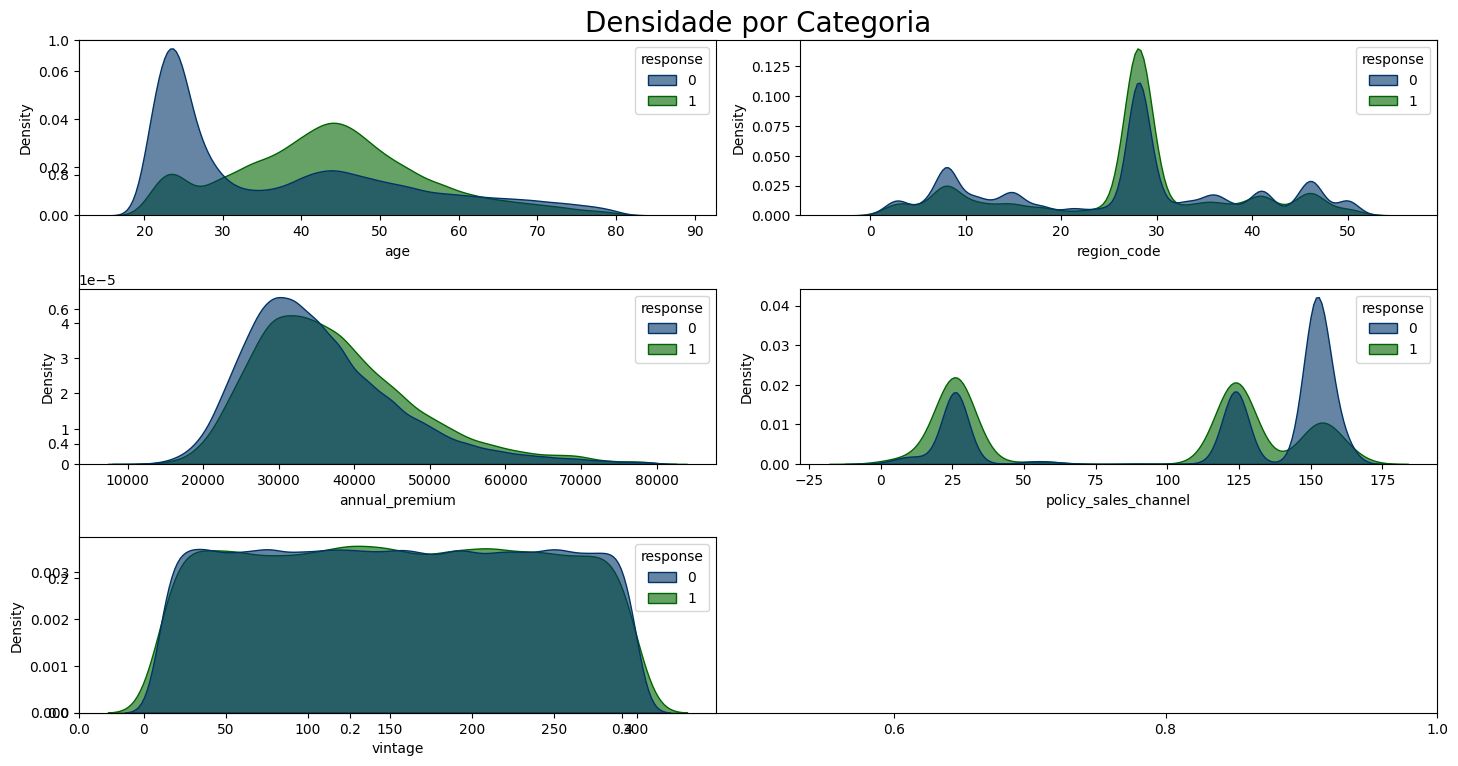

In [21]:
df_combined = df_number.copy()
df_combined['response'] = df1['response']
# retirando os outliers para entender melhor a distribuição de 'annual_premium'
aux = df_combined.loc[(df_combined['annual_premium']<80000) & (df_combined['annual_premium']>10000)]

plt.figure(figsize=(15, 8))
plt.title('Densidade por Categoria',size = 20)
for n, coluna in enumerate(df_number.columns, start=1):
    plt.subplot(3, 2, n)  
    sns.kdeplot(data=aux, x=coluna, hue='response', fill=True, common_norm=False, alpha=0.6)
    # plt.title(coluna)
    plt.tight_layout()

- Novamente 'age' chama atenção, porém demonstrando que clientes mais jovens tem um menor interesse em seguro de veículos. Essa informação será de grande valor para o modelo.
- Outras variaveis tambem demonstram um certo comportamento mas bem menos perceptivo.

### 3.1.3 Distribuição das Variáveis categóricas

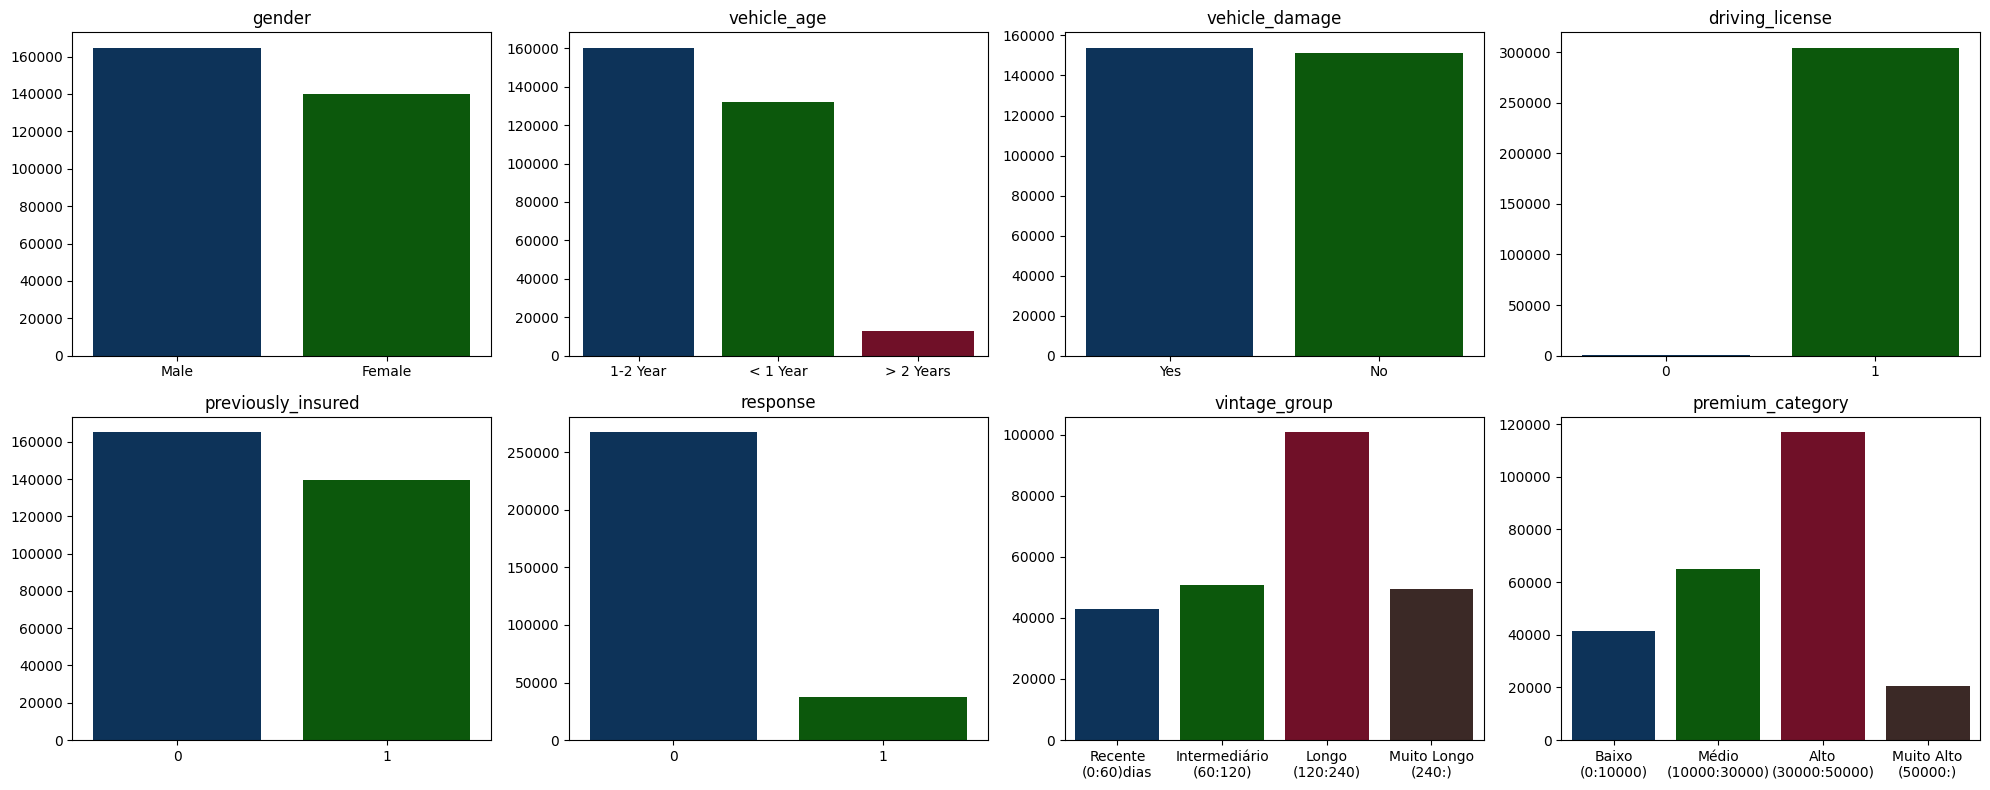

In [22]:
plt.figure(figsize=(20, 8))
df_object['vintage_group'] = df2['vintage_group']
df_object['premium_category'] = df2['premium_category']

for n, coluna in enumerate(df_object.columns, start=1):
    counts = df_object[coluna].value_counts()
    plt.subplot(2, 4, n) 
    sns.barplot( x=counts.index, y=counts.values, hue = counts.index)
    plt.xlabel('')
    plt.title(coluna)
    plt.legend([], frameon=False)
    plt.tight_layout()
    
    

## 3.2 Analise Bivariada

### 3.2.1 Distribuição regiões e canais de comunicação por interesse no produto

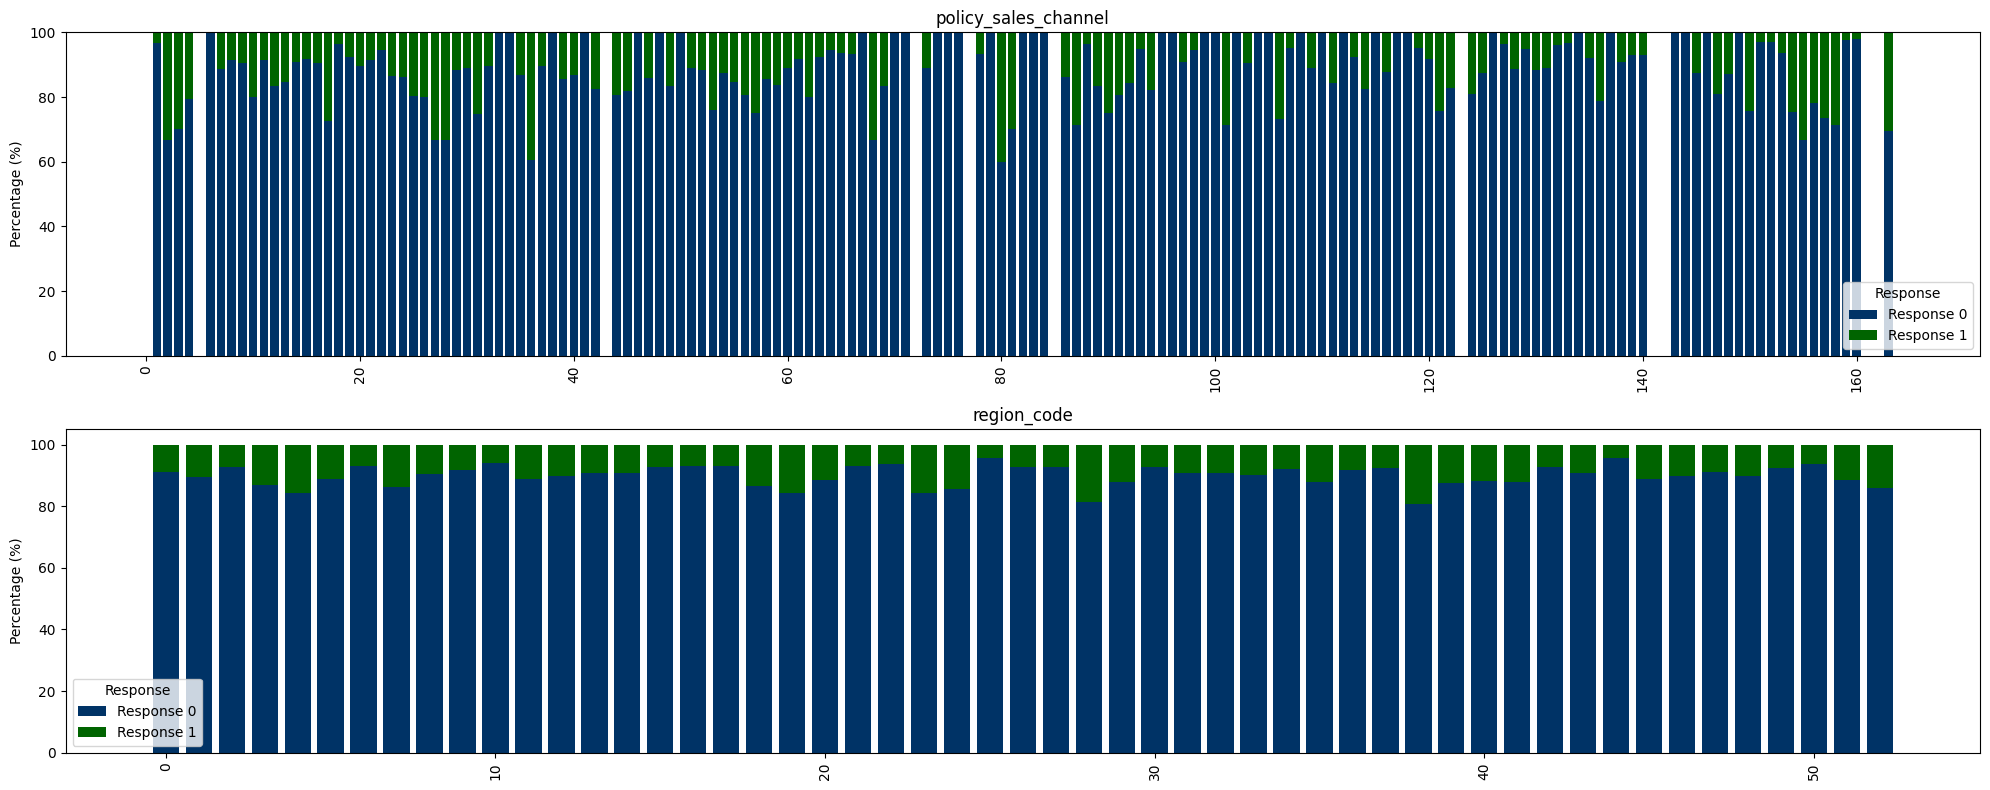

In [23]:
plt.figure(figsize=(20, 8))
aux = df2[['response', 'policy_sales_channel', 'region_code']]

for n, coluna in enumerate(aux.drop('response', axis=1).columns, start=1): 
    plt.subplot(2, 1, n)
    grouped = aux.groupby([coluna, 'response']).size()
    data_normalized = (
        grouped / grouped.groupby(level=0).sum() * 100
    ).unstack()  

    bottom = None
    for response in data_normalized.columns:
        plt.bar(
            data_normalized.index,
            data_normalized[response],
            bottom=bottom,  
            label=f"Response {response}"
        )
        bottom = (
            data_normalized[response]
            if bottom is None
            else bottom + data_normalized[response]
        )

    plt.ylabel("Percentage (%)")
    plt.title(f"{coluna}")
    plt.legend(title="Response")
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()


### 3.2.2 Distribuição de variaveis por categoria e por interesse no produto

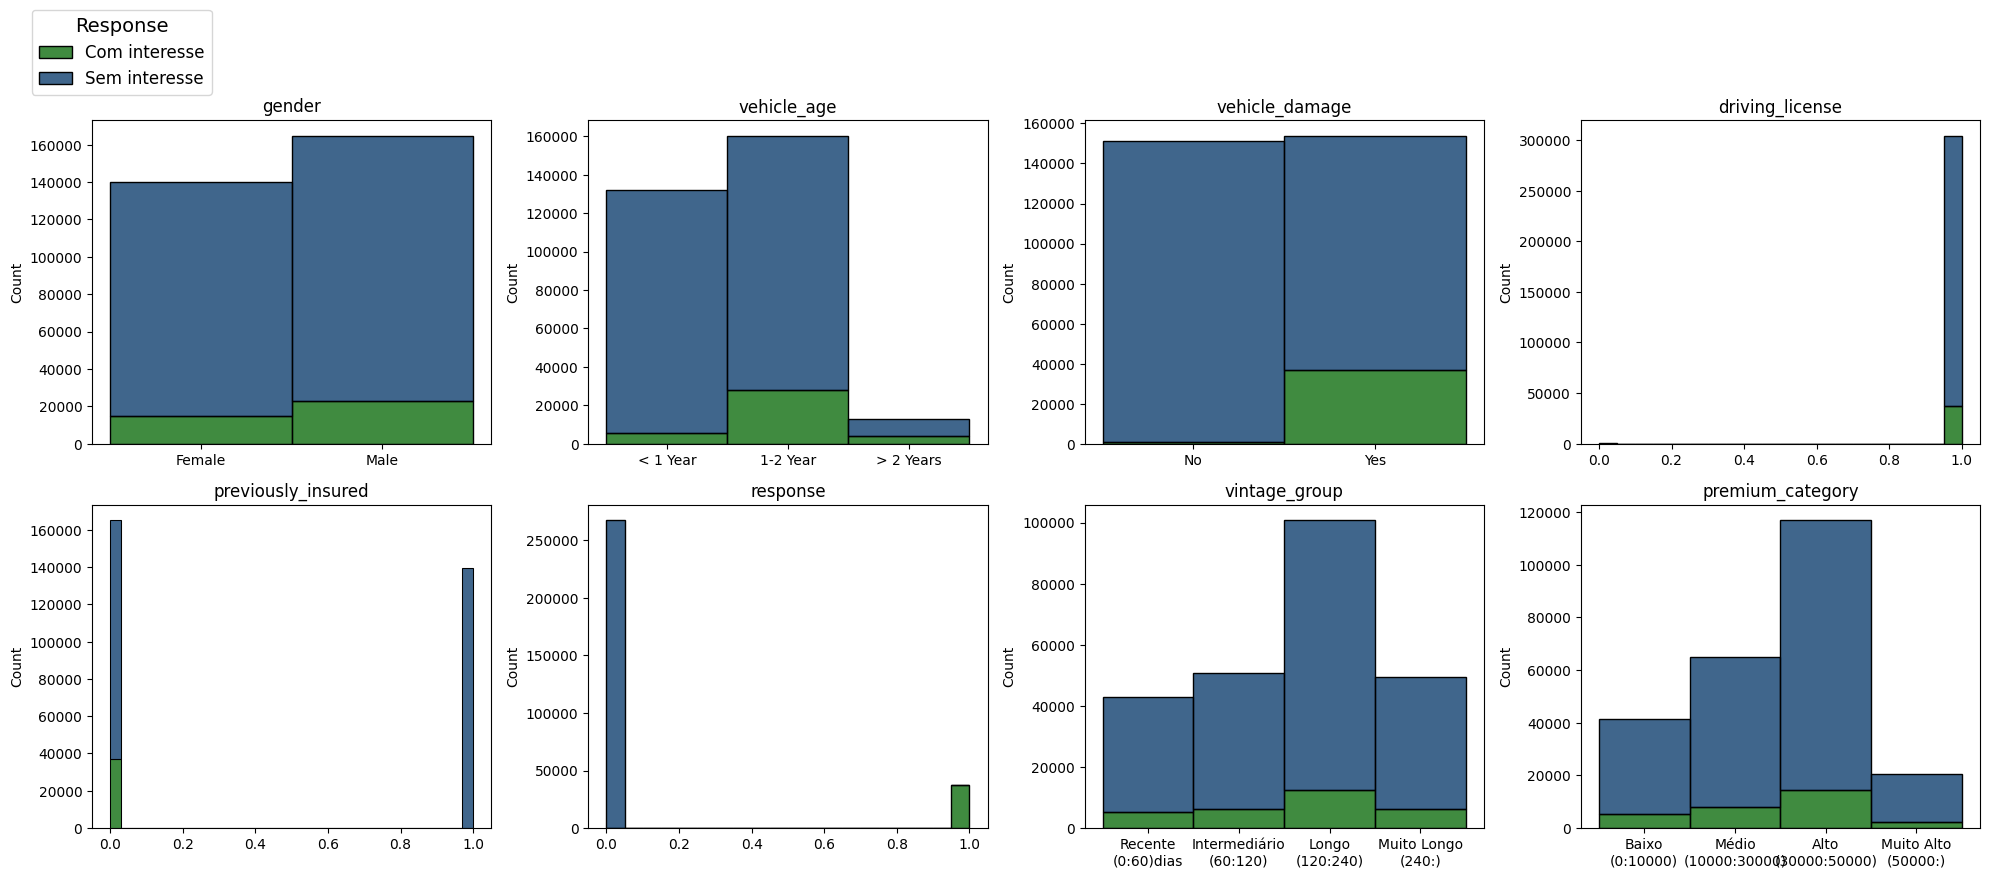

In [24]:
plt.figure(figsize=(20, 8))
for n, coluna in enumerate(df_object.columns, start=1): 
    plt.subplot(2, 4, n)
    sns.histplot(data=df_object, x=coluna, hue="response", multiple="stack")
    plt.title(coluna)
    plt.xlabel('')
    plt.legend([], frameon=False)
    plt.tight_layout()

plt.legend(
        title="Response",
        title_fontsize=14, fontsize=12, 
        labels=['Com interesse','Sem interesse'],
        loc="center left",
        bbox_to_anchor=(-3.9, 2.4))

plt.show()

- Clientes com veículos entre 1 e 2 anos são mais comumentes interessados no seguro.
- Pessoas que já sofreram danos em veículos tem maior interesse em contratar o seguro.
- Não existem ou existem muito poucas pessoas sem carteira de motorista na base de dados.
- Pessoas que já possuem seguro não tem interesse em contratar o seguro.

In [25]:
df_object['driving_license'].value_counts()

driving_license
1    304246
0       641
Name: count, dtype: int64

### 3.2.3 Validação de Hipóteses

#### H1. Clientes mais experientes (>=30 anos) têm maior propensão a contratar seguros para veículos por procurar segurança.  
**Verdadeira** Entre as faixas de 30 a 55 anos a porcentagem de interessse é proxima aos 20%

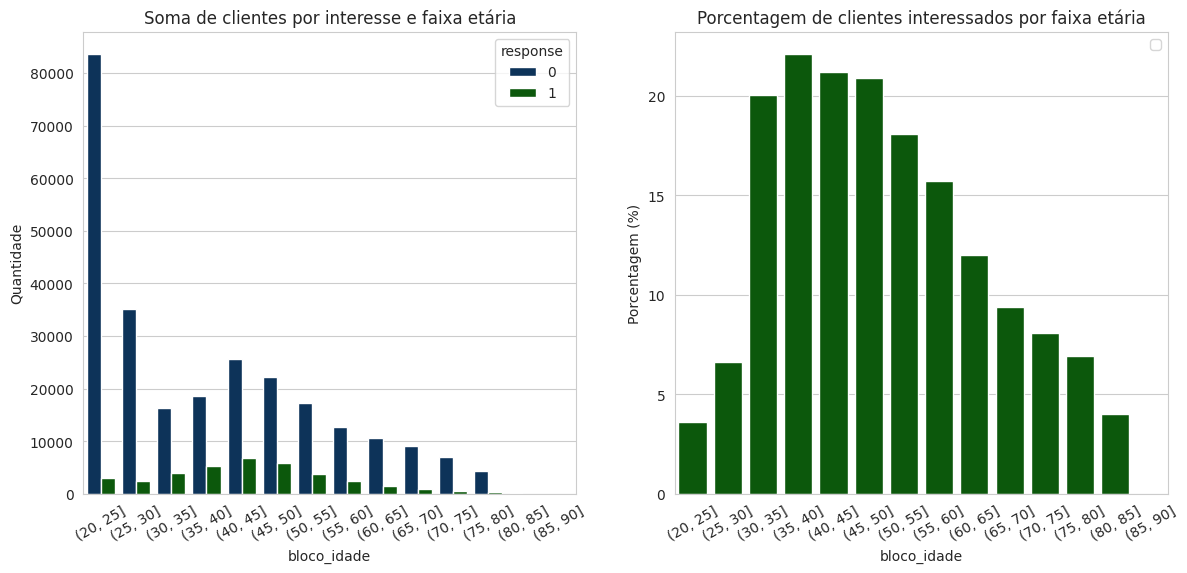

In [108]:
aux1 = df2.copy()
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
bins = list(range(20,91,5))
aux1['bloco_idade'] = pd.cut(aux1['age'],bins=bins)
aux2 = aux1.loc[:,['id','bloco_idade', 'response']].groupby(['bloco_idade','response'],observed=False).count().reset_index()
sns.barplot(data = aux2, x='bloco_idade', y= "id",hue='response')
plt.ylabel('Quantidade')
plt.xticks(rotation = 30);
plt.title('Soma de clientes por interesse e faixa etária');

plt.subplot(1,2,2)
plt.title('Porcentagem de clientes interessados por faixa etária')
bins = list(range(20,91,5))
aux1['bloco_idade'] = pd.cut(aux1['age'],bins=bins)
aux3 = aux1.loc[:,['id','bloco_idade', 'response']].groupby(['bloco_idade','response'],observed=False).count().reset_index()
total_por_faixa = aux3.groupby('bloco_idade',observed=False)['id'].sum()
total_por_faixa_categoria = aux3.groupby(['bloco_idade', 'response'],observed=False)['id'].sum()
porcentagem_categoria = (total_por_faixa_categoria / total_por_faixa) * 100
aux3 = pd.DataFrame(porcentagem_categoria).reset_index()
sns.barplot(data = aux3[aux3['response']==1], x='bloco_idade', y= "id", color=custom_palette[1])
plt.legend([])
plt.xticks(rotation = 30);
plt.ylabel('Porcentagem (%)');

plt.savefig('../img/faixa_etaria.png')

#### H2. Clientes que já possuem um histórico de seguro têm maior probabilidade de se interessar pelo seguro. 
**Falsa** Clientes que já possuem seguro para veículo não tem interesse.

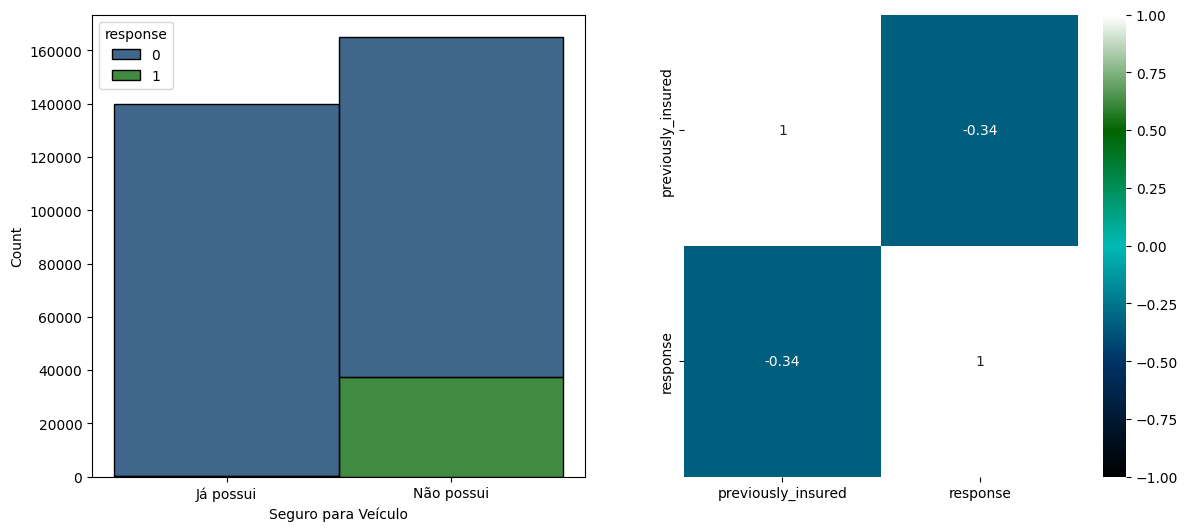

In [27]:
plt.figure(figsize =(14,6))

dfaux1 = df2.copy()
dfaux1['previously_insured'] = df2['previously_insured'].map(lambda x: 'Já possui' if x==1 else 'Não possui')
plt.subplot(1,2,1)
sns.histplot(data = dfaux1, x= 'previously_insured',hue = 'response',multiple='stack')
plt.xlabel('Seguro para Veículo')

plt.subplot(1,2,2)
dfaux = df2[['previously_insured','response']]

from matplotlib.colors import LinearSegmentedColormap
# Paleta de cores para headmap
custom_palette = ['#000000','#003366','#00bab4', '#006400','#FFFFFF']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_palette)

sns.heatmap(dfaux.corr(method='pearson'), annot=True, vmin=-1, vmax=1, cmap=custom_cmap);

#### H3. Mulheres tem maior propenção para contratar seguros, priorizando segurança. 
**Falsa** O gênero pouca ou nenhuma correlação com a propenção de interesse no seguro para veículo, apenas 5% maior para homens.

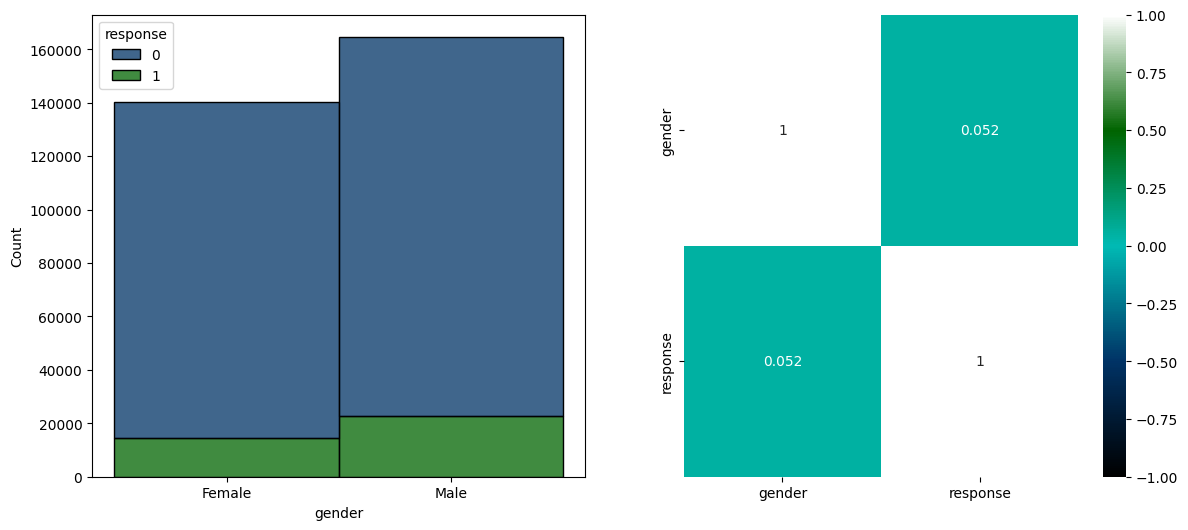

In [28]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.histplot(data = dfaux1, x= 'gender',hue = 'response',multiple='stack')

plt.subplot(1,2,2)
dfaux = df2[['gender','response']].copy()
dfaux['gender'] = dfaux['gender'].map(lambda x: 1 if x=='Male' else 0)
sns.heatmap(dfaux.corr(method='pearson'), annot = True, vmin=-1, vmax=1, cmap = custom_cmap);

#### H4. Clientes que já sofreram danos em veículos no passado têm maior chance de contratar seguros. 
**Verdadeira** Clientes que já sofreram danos em seus veículos tem maiores chances de contratar o seguro. 

In [29]:
dfaux1['vehicle_damage'].value_counts()

vehicle_damage
Yes    153862
No     151025
Name: count, dtype: int64

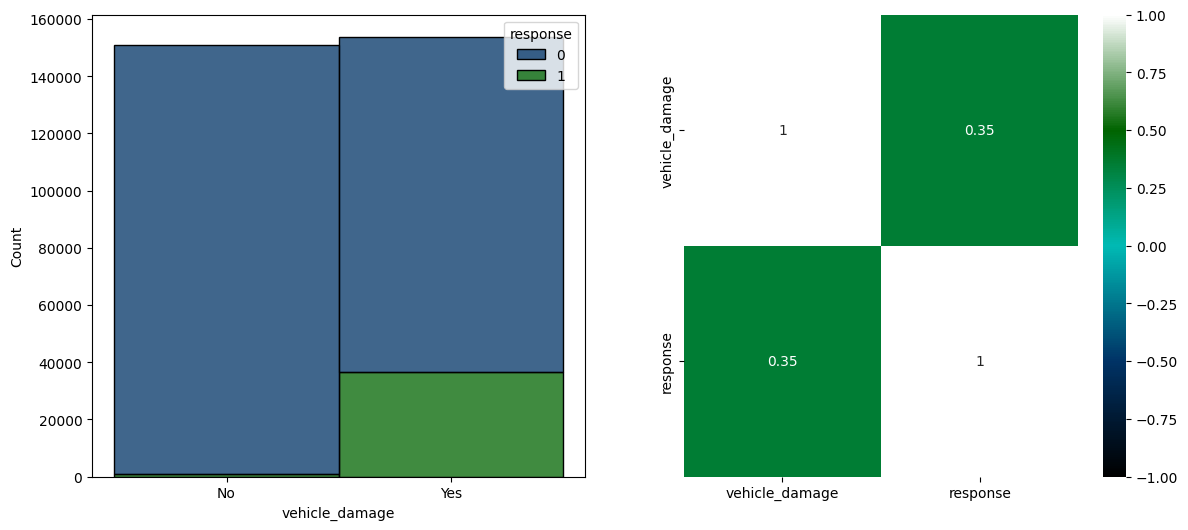

In [30]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.histplot(data = dfaux1, x= 'vehicle_damage',hue = 'response', multiple = 'stack')

plt.subplot(1,2,2)
dfaux = df2[['vehicle_damage','response']].copy()
dfaux['vehicle_damage'] = dfaux['vehicle_damage'].map(lambda x: 1 if x=='Yes' else 0)
aux1 = dfaux.corr(method='pearson')
sns.heatmap(aux1, annot = True, vmin=-1, vmax=1, cmap = custom_cmap);

#### H5. Planos com preços mais acessíveis atraem clientes jovens ou com menor histórico de seguro. 
**Falsa** Clientes jovens além de pouco interesse por seguros preferem seguros de preços 'Altos' ou 'Médios'

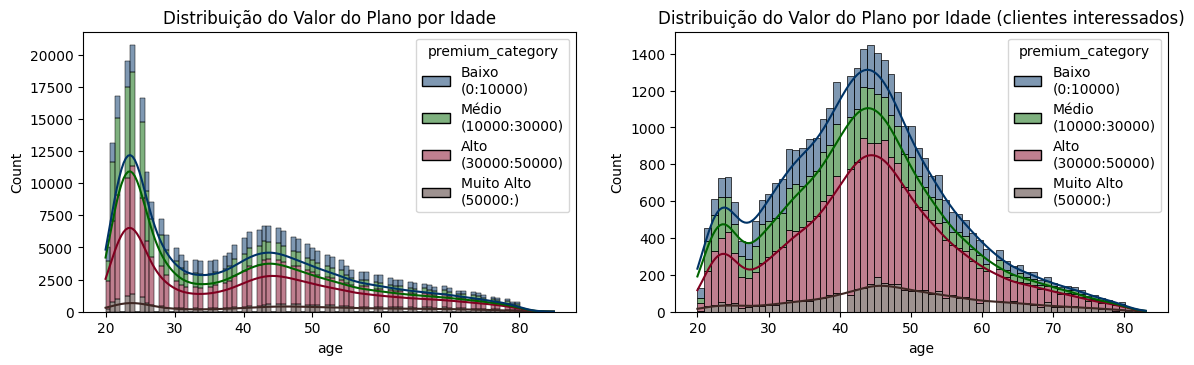

In [31]:
# sns.scatterplot(data = df2[:500], x='age', y='annual_premium', hue = 'response')
aux = df2.copy()
plt.figure(figsize = (14,8))

plt.subplot(2,2,1)

plt.title('Distribuição do Valor do Plano por Idade')
sns.histplot(data=aux, x='age', hue='premium_category', kde=True, multiple='stack')

plt.subplot(2,2,2)
plt.title('Distribuição do Valor do Plano por Idade (clientes interessados)')
aux1 = aux[aux['response']==1]
sns.histplot(data=aux1, x='age', hue='premium_category', kde=True, multiple='stack');



#### H6. Clientes com mais tempo de casa tem maior propenção de desejar o novo produto. 
**Falsa** Não há correlação entre o tempo e o interesse no seguro.

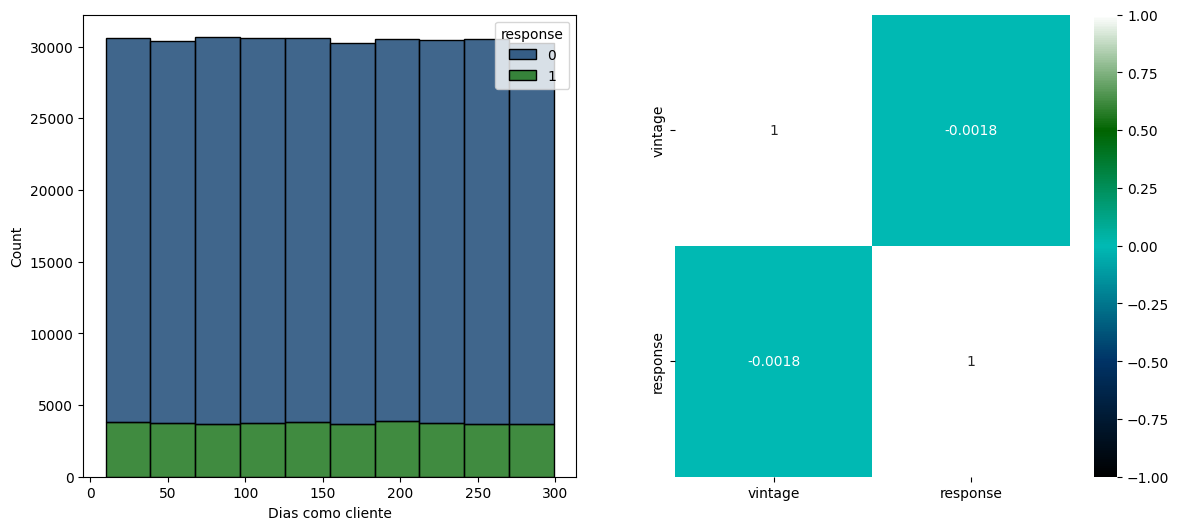

In [32]:
plt.figure(figsize=(14,6))
# aux = df2[df2['response']==1]
plt.subplot(1,2,1)
sns.histplot(data=aux, x='vintage', hue='response', multiple='stack', bins = 10)

plt.xlabel('Dias como cliente')
plt.subplot(1,2,2)
aux = df2[['vintage','response']]
aux1 = aux.corr(method='pearson')
sns.heatmap(aux1, annot = True, vmin=-1, vmax=1, cmap = custom_cmap);

#### H7. Clientes com veículos mais novos são mais comumentes interessados no seguro. 
**Falsa** A maior parte dos clientes interessados tem veículos com mais de 1 ano.

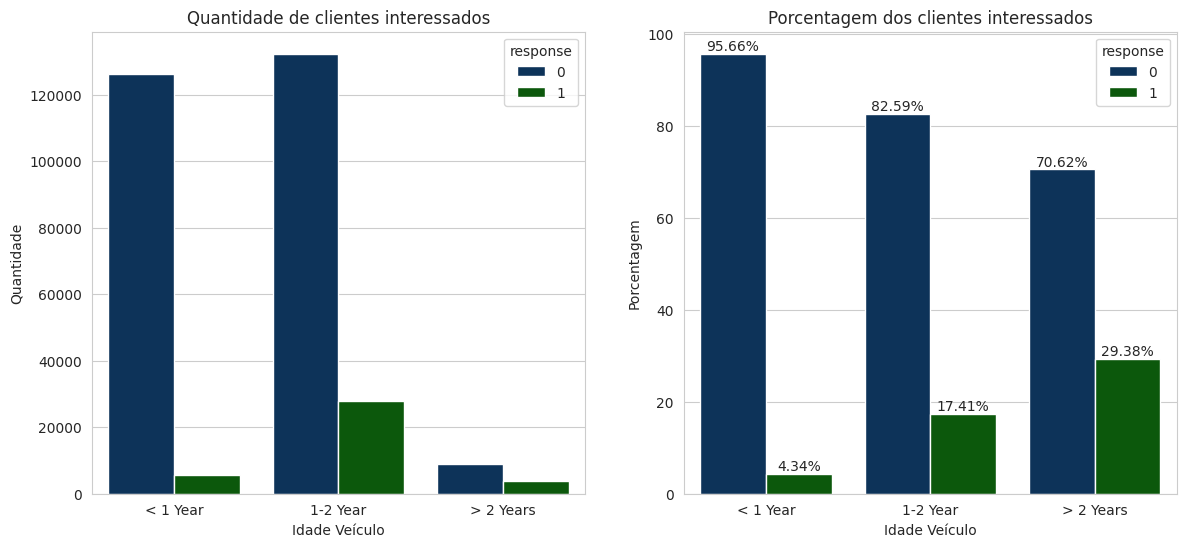

In [111]:
plt.figure(figsize = (14,6))

plt.subplot(1,2,1)
aux = df2.loc[:,['id', 'vehicle_age','response']].groupby(['vehicle_age', 'response']).count().reset_index()
aux['age_new'] = aux['vehicle_age'].apply(lambda x: 0 if x=='< 1 Year' else 1 if x=='1-2 Year' 
                                                   else 2 if x=='> 2 Years'else x)
aux = aux.sort_values('age_new')
sns.barplot(data = aux, x= 'vehicle_age', y='id', hue='response', estimator="sum")
plt.title('Quantidade de clientes interessados')
plt.ylabel('Quantidade');
plt.xlabel('Idade Veículo')



plt.subplot(1,2,2)
aux1 = df2.loc[:,['id', 'vehicle_age','response']].groupby(['vehicle_age', 'response']).count().reset_index()
aux1['age_new'] = aux1['vehicle_age'].apply(lambda x: 0 if x=='< 1 Year' else 1 if x=='1-2 Year' 
                                                   else 2 if x=='> 2 Years'else x)
aux1 = aux1.sort_values('age_new')
aux1['porcentagem'] = aux1.groupby('vehicle_age')['id'].transform(lambda x: x/x.sum() * 100)

ax = sns.barplot(data = aux1, x= 'vehicle_age', y='porcentagem', hue='response')

for container in ax.containers:
    labels = [f"{v.get_height():.2f}%" for v in container]  
    ax.bar_label(container, labels=labels, fontsize=10)
plt.title('Porcentagem dos clientes interessados');
plt.xlabel('Idade Veículo')
plt.ylabel('Porcentagem')

# salvando imagem
plt.savefig('../img/idade_veiculo.png')



#### H8. Clientes em regiões onde há maior proporção de veículos danificados têm maior probabilidade de contratar seguros.
**Verdadeira** Clientes em regiões onde a porcentagem de veículos que já foram danificados é relevante tem uma maior propenção a desejar um seguro.

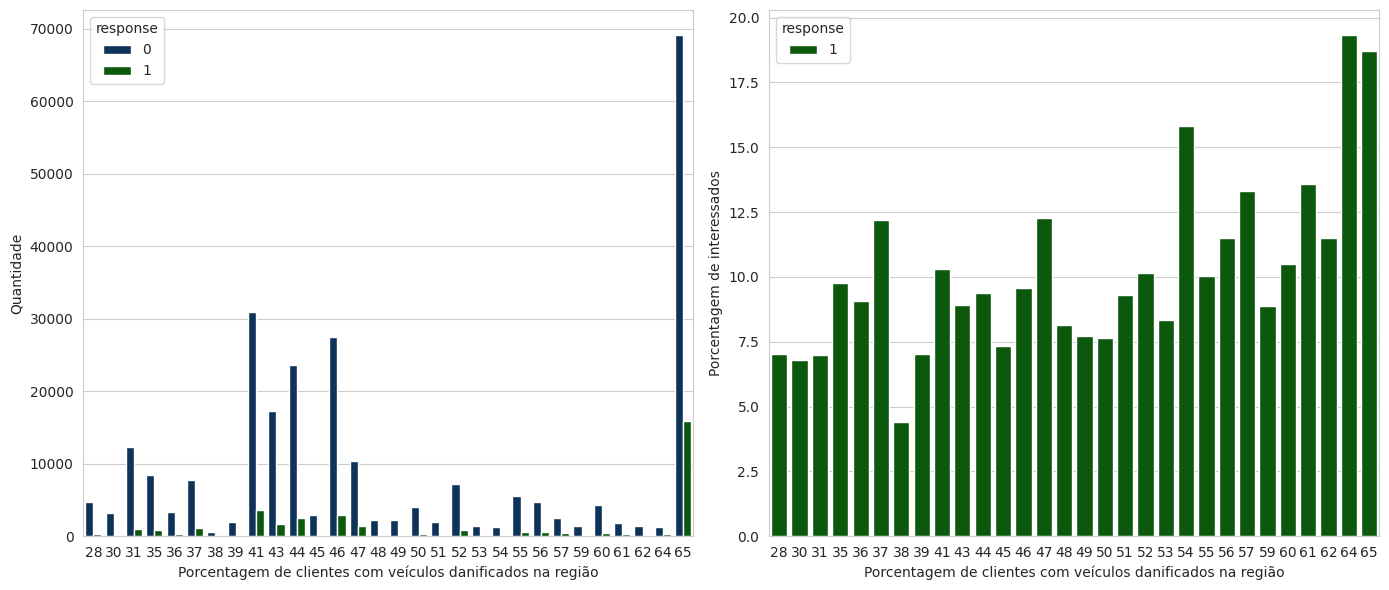

In [103]:
aux =df2[['pct_damage_region','response']].groupby(['pct_damage_region','response']).agg({'response':'count'})
aux.columns = ['count']
aux = aux.reset_index()

total_por_faixa = aux.groupby('pct_damage_region',observed=False)['count'].sum()
total_por_faixa_categoria = aux.groupby(['pct_damage_region', 'response'],observed=False)['count'].sum()
porcentagem_categoria = pd.DataFrame((total_por_faixa_categoria/ total_por_faixa)*100).reset_index()
aux['pct_response'] = porcentagem_categoria['count']
aux.head(4)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title('')
sns.barplot(x='pct_damage_region', y= 'count', data=aux, hue = 'response', errorbar = None)
plt.xlabel('Porcentagem de clientes com veículos danificados na região')
plt.ylabel('Quantidade')

plt.subplot(1,2,2)

sns.barplot(x='pct_damage_region', y='pct_response', data=aux[aux['response'] == 1], hue='response', palette=['#006400'])


plt.xlabel('Porcentagem de clientes com veículos danificados na região')
plt.ylabel('Porcentagem de interessados')

plt.tight_layout()
plt.savefig('../img/pct_damage.png')

## 3.3 Analise Multivariada

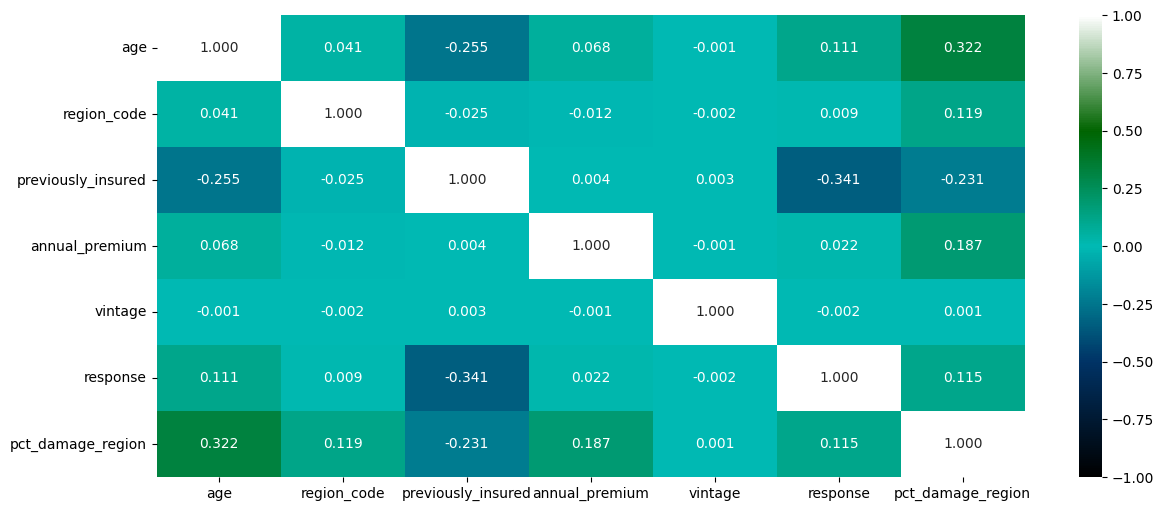

In [35]:
df_number = df2.select_dtypes(include = ['int64', 'float64', 'int32'])
df_number = df_number[['age', 'region_code','previously_insured','annual_premium','vintage','response','pct_damage_region']]

correlation = df_number.corr(method = 'pearson')
plt.figure(figsize = (14,6))
sns.heatmap(data = correlation, annot=True, vmin=-1, vmax=1, cmap=custom_cmap,fmt='.3f',);

## 3.4 Principais Insigths

- #### 1. Se a região do cliente possui alta taxa de clientes com veículos danificados a chance dele querer um seguro é maior.
- #### 2. Clientes com veículos entre 1 e 2 anos são mais comumentes interessados no seguro.
- #### 3. Pessoas que já sofreram danos em veículos tem maior interesse em contratar o seguro.
- #### 4. Pessoas que já possuem seguro não tem interesse em contratar o seguro.
- #### 5. O gênero do cliente não possui relevância.
- #### 6. O tempo de relacionamento com o cliente não tem relevância.
- #### 7. Clientes com mais de 30 anos tem um maior interesse no seguro.

# 4.0 - Preparação dos Dados

## 4.0.1 Splitting data into training and validation

In [36]:
df4 = df2.drop(['total_veiculos_regiao','veiculos_danificados_regiao'],axis=1)

In [37]:
X = df4.drop('response',axis=1)
y = df4['response']
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 12)
df4 = pd.concat([X_train,y_train], axis=1)
df_validation = pd.concat([X_val,y_val], axis=1)

## 4.1 Standartzation (Padronização) 

In [38]:
ss = StandardScaler()

df4['annual_premium'] = ss.fit_transform(df4[['annual_premium']])


## 4.2 Normalização (Rescaling)

In [39]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()
mms_damage = MinMaxScaler()

# Min Max Scaler
df4['age'] =                  mms_age.fit_transform(df4[['age']].values)
df4['vintage'] =              mms_vintage.fit_transform(df4[['vintage']])
df4['pct_damage_region'] =    mms_damage.fit_transform(df4[['pct_damage_region']])

## 4.3 Encoding

In [40]:
# encoding para modelos lineares devem ser diferentes em relação a modelos não lineares

# gender - One-Hot Encoding / Target Encoding
target_gender =  df4.groupby('gender')['response'].mean()
df4['gender'] = df4['gender'].map(target_gender)

# policy_sales_channel- Target Encoding/ Frequency Encoding
target_policy_sales =  df4.groupby('policy_sales_channel')['response'].mean()
df4['policy_sales_channel'] = df4['policy_sales_channel'].map(target_policy_sales)

# vehicle_damage - One-Hot Encoding / Target Encoding
target_vehicle_damage = df4.groupby('vehicle_damage')['response'].mean()
df4['vehicle_damage'] = df4['vehicle_damage'].map(target_vehicle_damage)

# region_code - Frequency Encoding / Target Encoding
frequency_region_code = df4['region_code'].value_counts(normalize=True)
df4['region_code'] = df4['region_code'].map(frequency_region_code)

# vehicle_damage - Label Encoding / Target Encoding
df4['vehicle_age'] = df4['vehicle_age'].apply(lambda x: 0 if x=='< 1 Year'
                                                    else 1 if x=='1-2 Year'
                                                    else 2 if x=='> 2 Years'
                                                    else x)

# premium_category - Label Encoding / Target Encoding
df4['premium_category'] = df4['premium_category'].apply(lambda x: 0. if x=='Baixo\n(0:10000)'
                                                             else 1 if x=='Médio\n(10000:30000)'
                                                             else 2 if x=='Alto\n(30000:50000)'
                                                             else 3 if x=='Muito Alto\n(50000:)'
                                                             else x).astype(int)

# vintage_group - Label Encoding / Target Encoding
df4['vintage_group'] = df4['vintage_group'].apply(lambda x: 0 if x=='Recente\n(0:60)dias'
                                                       else 1 if x=='Intermediário\n(60:120)'
                                                       else 2 if x=='Longo\n(120:240)'
                                                       else 3 if x=='Muito Longo\n(240:)'
                                                       else x).astype(int)


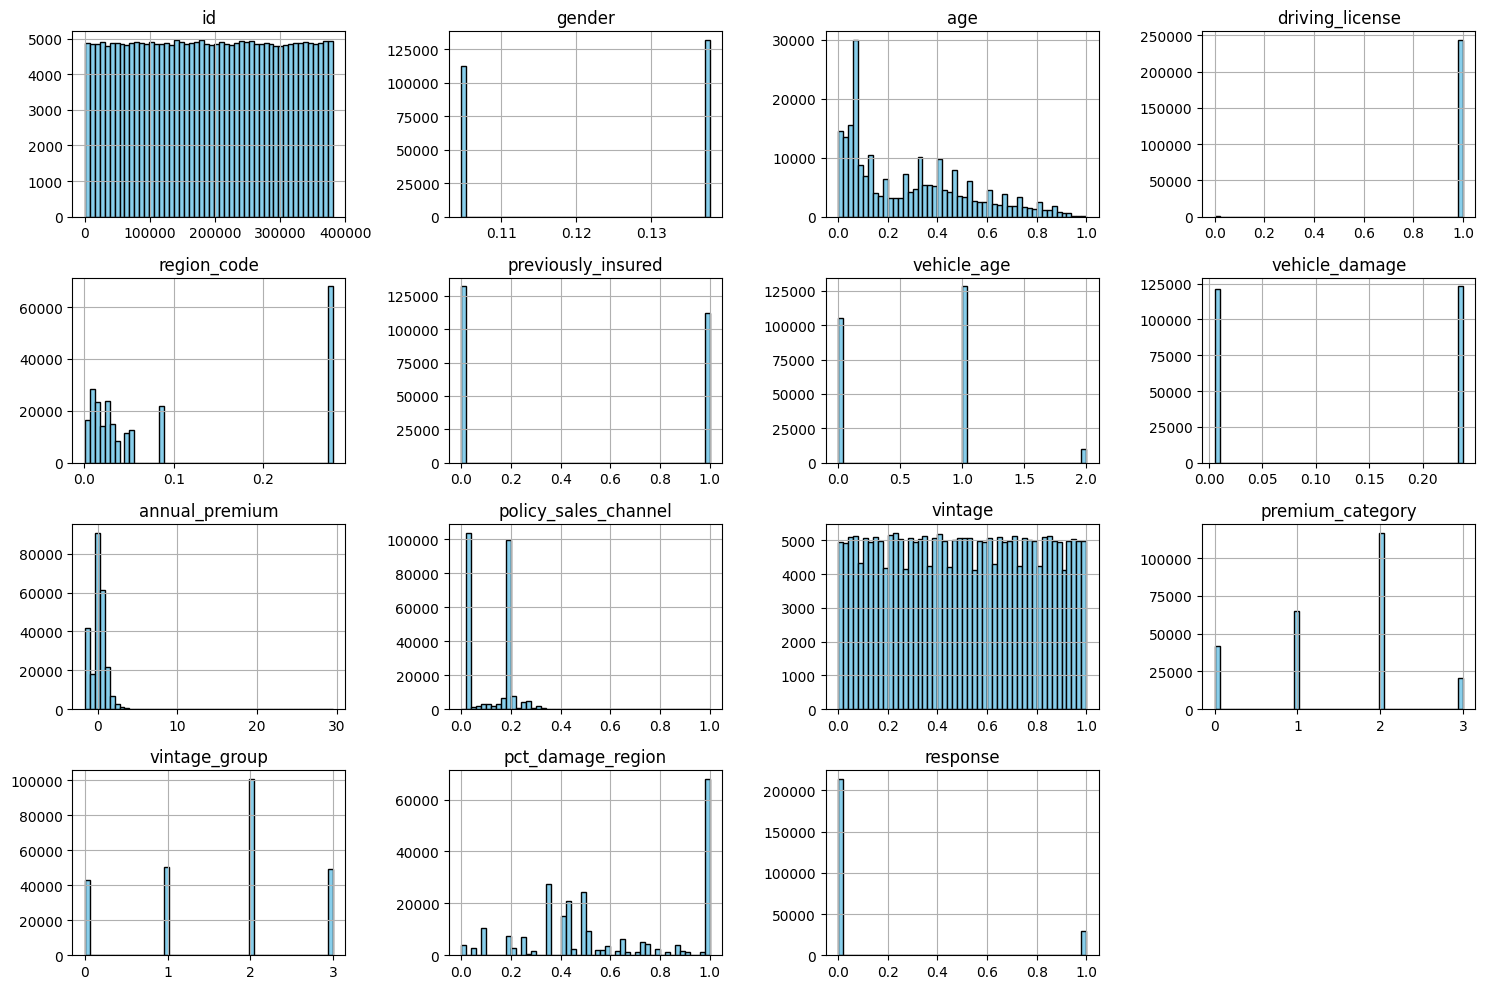

In [41]:
df4.hist(bins=50, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.tight_layout()

In [42]:
df4.describe().T

,count,mean,std,min,25%,50%,75%,max
id,243909.0,1.906321e+05,110017.913795,2.000000,95415.000000,190472.000000,285756.000000,381109.000000
gender,243909.0,1.225621e-01,0.016463,0.104721,0.104721,0.137754,0.137754,0.137754
age,243909.0,2.891622e-01,0.238498,0.000000,0.076923,0.246154,0.446154,1.000000
driving_license,243909.0,9.979706e-01,0.045004,0.000000,1.000000,1.000000,1.000000,1.000000
region_code,243909.0,9.983609e-02,0.113245,0.000459,0.014485,0.034964,0.278588,0.278588
previously_insured,243909.0,4.590360e-01,0.498320,0.000000,0.000000,0.000000,1.000000,1.000000
vehicle_age,243909.0,6.094486e-01,0.567368,0.000000,0.000000,1.000000,1.000000,2.000000
vehicle_damage,243909.0,1.225621e-01,0.116211,0.005367,0.005367,0.237797,0.237797,0.237797
annual_premium,243909.0,-5.651505e-17,1.000002,-1.621268,-0.357510,0.062989,0.511915,29.564259
policy_sales_channel,243909.0,1.225621e-01,0.086839,0.000000,0.028617,0.175383,0.198907,1.000000


## 4.4 Validation Preparation

In [43]:
encoders = [ss, mms_age, mms_vintage, mms_damage, target_policy_sales,
            target_vehicle_damage,frequency_region_code]

# salvando encoders
damage_region = merged['pct_damage_region'].to_dict()
final_encoders = encoders.copy()
final_encoders.append(damage_region)  

file_path = "../src/features/encoders.pkl"
# Salvando com pickle
with open(file_path, "wb") as f:
    pickle.dump(final_encoders, f)

X_val = preparation_val(X_val, encoders)


# 5.0 Feature Selection

In [44]:
X = df4.drop(columns = ['id', 'response'])
y = df4['response']

## 5.1 Seleção Univariada

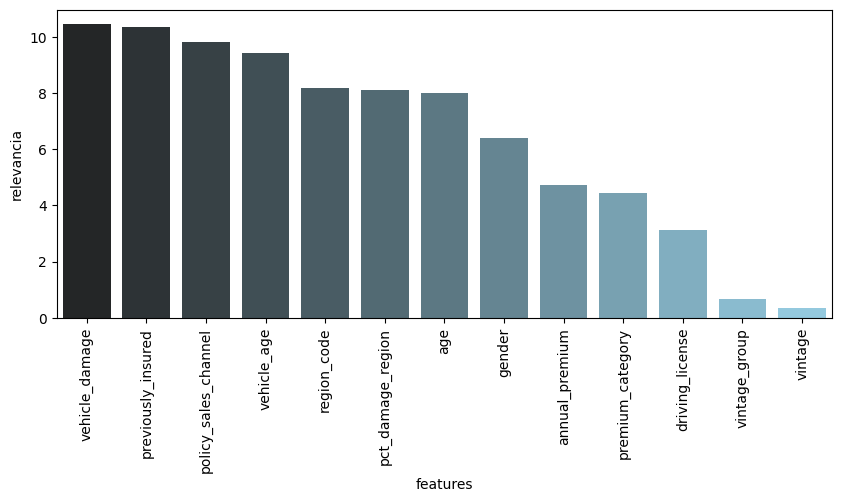

In [45]:
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)
features_univariada = pd.DataFrame({'features': X.columns,
              'relevancia': np.round(np.log(selector.scores_),2)}).sort_values(by='relevancia', ascending = False).reset_index(drop=True)

plt.figure(figsize = (10,4))
sns.barplot(x=features_univariada['features'], y= features_univariada['relevancia'],hue = features_univariada['features'],palette='dark:skyblue' )
plt.xticks(rotation=90);

## 5.2 Seleção por Random Forest

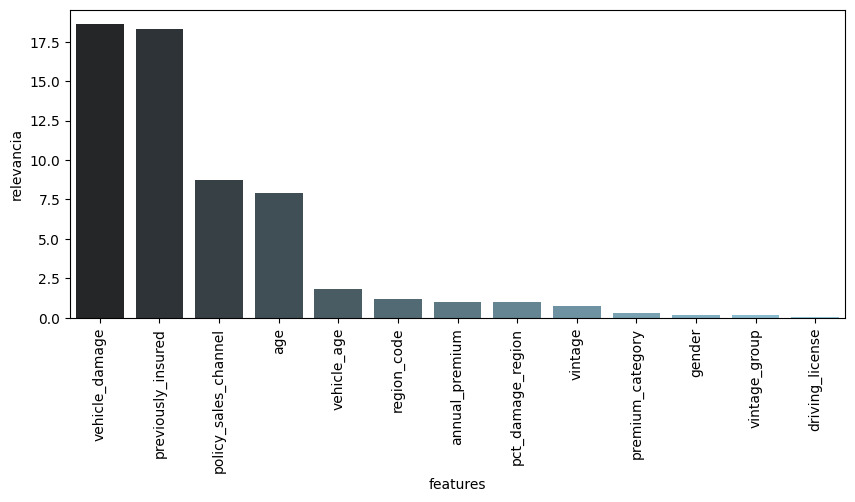

In [46]:
model = RandomForestClassifier(min_samples_split=5, max_depth=10, n_estimators = 50, random_state = 0)
model.fit(X, y)

# Importância das características
importances = model.feature_importances_

features_RandomForest = pd.DataFrame({'features': X.columns,
              'relevancia': np.round(importances*60,2)}).sort_values(by='relevancia', ascending = False).reset_index(drop=True)

plt.figure(figsize = (10,4))
sns.barplot(x=features_RandomForest['features'], y= features_RandomForest['relevancia'],hue = features_univariada['features'],palette='dark:skyblue');
plt.legend().remove()
plt.xticks(rotation=90);

## 5.3 Seleção final de features 

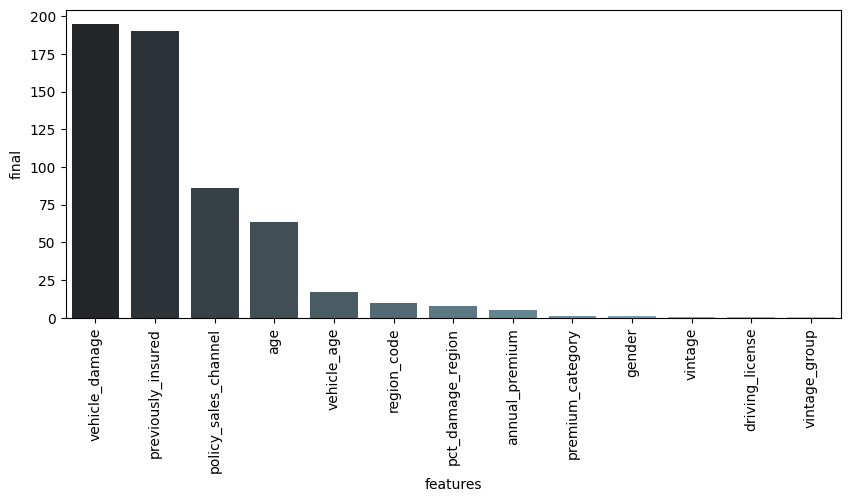

In [47]:
features = pd.merge(features_univariada, features_RandomForest,on= 'features', how = 'outer').sort_values(by='relevancia_y',ascending = False)
features['final'] = features['relevancia_x'] * features['relevancia_y']
features = features.sort_values(by='final', ascending = False).reset_index(drop=True)
plt.figure(figsize = (10,4))
sns.barplot(x=features['features'], y= features['final'],hue = features_univariada['features'],palette='dark:skyblue')
plt.legend().remove()
plt.xticks(rotation=90);

In [48]:
columns = ['age', 'region_code', 'previously_insured',
       'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'pct_damage_region']

## 5.4 Save Data

In [49]:
df_train_ready = pd.concat([df4[columns],df4['response']],axis=1)
df_val_ready =   pd.concat([X_val[columns],y_val], axis=1)

df2.to_csv('../data/data_cross_val.csv',index=False)
df_train_ready.to_csv('../data/train_data_ready.csv',index=False)
df_val_ready.to_csv('../data/val_data_ready.csv',index=False)

# 6.0 Machine Learning Modeling

## 6.1 Load data 

In [50]:
train = pd.read_csv('../data/train_data_ready.csv')
val =   pd.read_csv('../data/val_data_ready.csv')

X_train = train.drop('response', axis=1)
y_train = train['response']

X_val = val.drop('response', axis=1)
y_val = val['response']

df_cross_val = pd.read_csv('../data/data_cross_val.csv')
df2 = df_cross_val.copy()

## 6.2 Testando Modelos / Aplicando métricas

### 6.2.1 Decision Tree 

- O baseline foi calculado simulando chamadas aleatórias para os clientes, fornecendo uma referência para avaliar o ganho obtido com técnicas mais avançadas. Além disso, utilizei uma árvore de decisão extremamente simples, que dividiu os clientes entre aqueles que possuem e os que não possuem seguro de veículos. Com base nesse modelo, ao ligar para os 40% dos clientes com maior probabilidade de compra, foi possível capturar 70% dos interessados no produto.

Precision Top K: 0.2230
Recall Top K: 0.5969


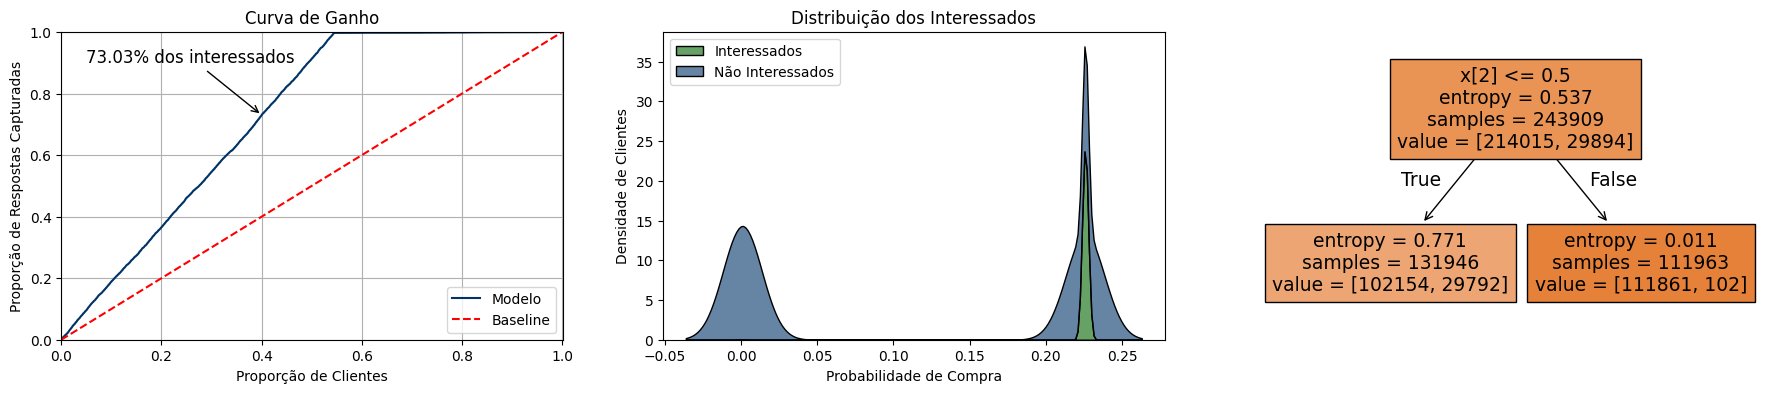

In [51]:
# criando modelo Decision Tree extremamente simples para utilizar como baseline
tree = DecisionTreeClassifier(criterion='entropy',random_state = 12, min_samples_split=50, max_depth=1,min_samples_leaf=2)

# Treinando o modelo
tree.fit(X_train, y_train)

yproba_tree = tree.predict_proba(X_val)

curva_ganho(yproba_tree, y_val, subplot=3, figsize = (22,4), text=(0.05,0.9), pct_clientes=0.40)
plt.subplot(1,3,3)
plot_tree(tree, filled=True);

print(f'Precision Top K: {precision_top_k(df_validation, yproba_tree, k=20000):.4f}')
print(f'Recall Top K: {recall_top_k(df_validation, yproba_tree, k=20000):.4f}')


### 6.2.2 Logistic Regression  

- Com a aplicação de uma regressão logística, a curva de ganho melhorou significativamente. Ao ligar para os 40% dos clientes com maior probabilidade de compra, foi possível capturar mais de 90% dos interessados no produto.

Precision Top K: 0.3067
Recall Top K: 0.8207


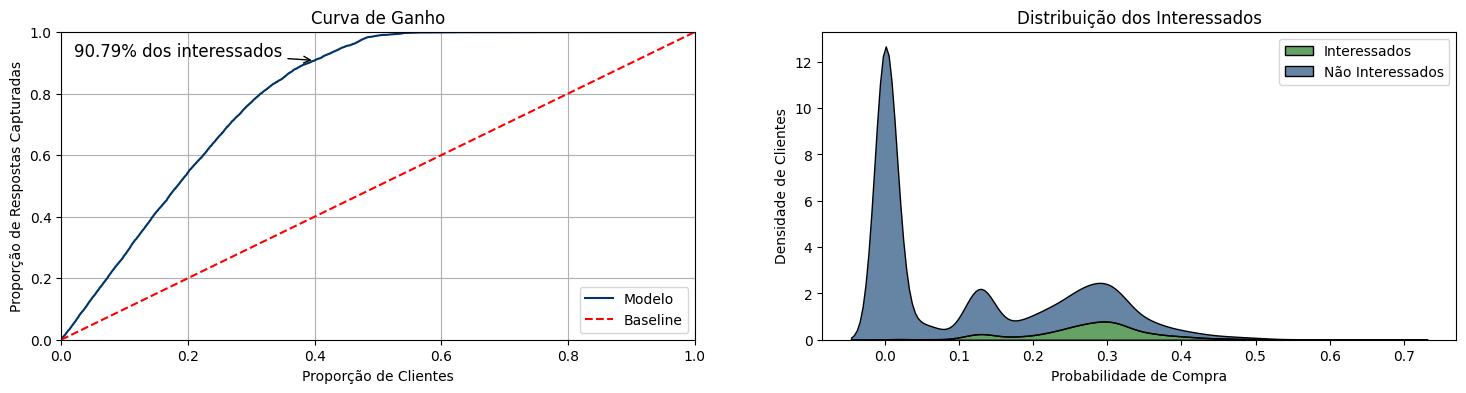

In [52]:
# define 
logistic = LogisticRegression(random_state = 1, max_iter = 1000,penalty='l1', solver='liblinear')

# Train
logistic.fit(X_train, y_train)

# proba
yproba_logistic = logistic.predict_proba(X_val)

# graficos para visualização
curva_ganho(yproba_logistic, y_val, figsize = (18,4), text = (0.02,0.92))

# Medida Precision
print(f'Precision Top K: {precision_top_k(df_validation, yproba_logistic, k=20000):.4f}')
print(f'Recall Top K: {recall_top_k(df_validation, yproba_logistic, k=20000):.4f}')


### 6.2.3 Random Forest

- A Random Forest trouxe mais uma melhoria na curva de ganho, capturando 92% dos interessados em 40% dos clientes.

Precision Top K: 0.3109
Recall Top K: 0.8321


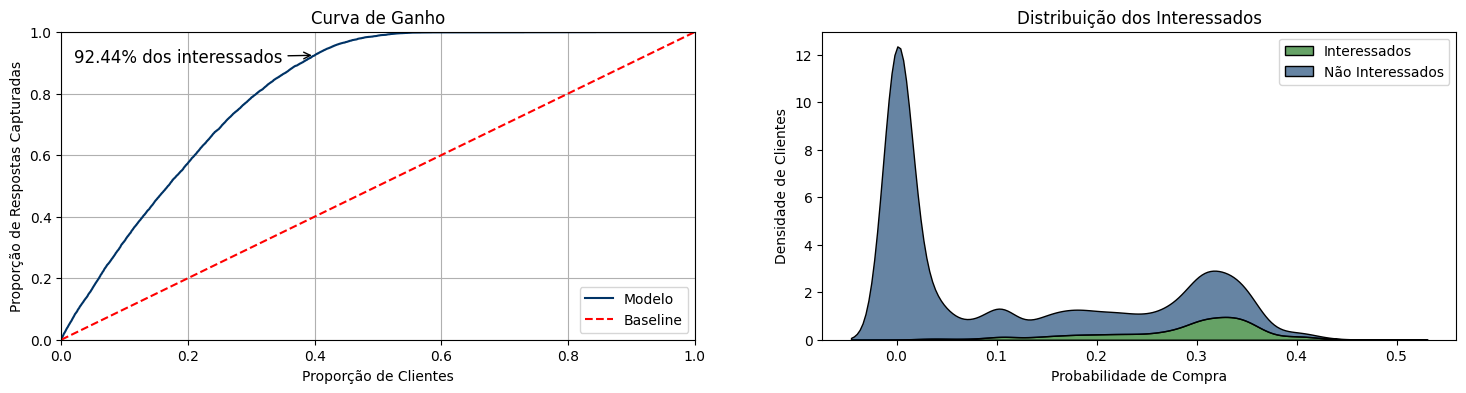

In [53]:
rf = RandomForestClassifier(n_estimators=101,min_samples_split=5, max_depth=10,random_state = 0)

# Treinando o modelo
rf.fit(X_train, y_train)

yproba_rf = rf.predict_proba(X_val)

curva_ganho(yproba_rf, y_val, figsize = (18,4), text = (0.02,0.9))

print(f'Precision Top K: {precision_top_k(df_validation, yproba_rf, k=20000):.4f}')
print(f'Recall Top K: {recall_top_k(df_validation, yproba_rf, k=20000):.4f}')


## 6.3 Aplicando Cross Validation para ajuste de hiperparametros 

In [54]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, 10, 12, 15, 17],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}


rf = RandomForestClassifier(random_state=0)

# melhores_parametros, melhor_k = params_tuning(rf, param_grid, df_cross_val)
# print(melhores_parametros)
# print(melhor_k)
# (n_estimators=100,min_samples_split=10, max_depth=12,random_state = 0,min_samples_leaf=4, max_features = 'sqrt', bootstrap= True)


## 6.4 Final model 

In [55]:
rf = RandomForestClassifier(n_estimators=100,min_samples_split=10, max_depth=12,random_state = 0,min_samples_leaf=4, max_features = 'sqrt', bootstrap= True)

cross_val_precision, cross_val_recall = cross_validation_pipeline(df2, n_splits=5, model=rf, k=20000)

# curva_ganho(yproba_rf, y_val, figsize = (18,4), text = (0.02,0.9))
print(f'Precision Top K with cross-val: {(cross_val_precision):.4f}')
print(f'Recall Top K with cross-val: {(cross_val_recall):.4f}')


Precision Top K with cross-val: 0.3116
Recall Top K with cross-val: 0.8339


# 7.0 Avaliação do modelo

## 7.1 Modelo Final em dados de Teste

In [56]:
y_test = dfy_test.copy()
X_test = dfx_test.copy()

#rename cols
cols = list(X_test.columns)
lista = [inflection.underscore(coluna) for coluna in cols ]
X_test.columns = lista

# add col pct_damage
X_test = pd.merge(X_test, merged['pct_damage_region'], on= 'region_code', how='left')

# preparation data
X_test = preparation_val(X_test, encoders)
# drop cols 
X_test = X_test.drop(['id','gender', 'vintage','driving_license'], axis=1)


Precision Top K: 0.3328
Recall    Top K: 0.7126


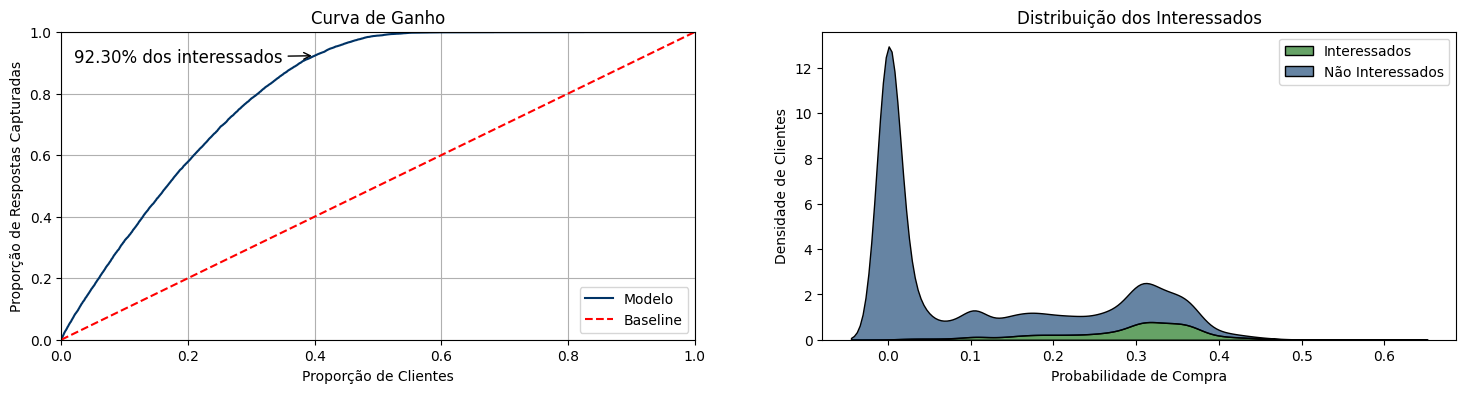

In [ ]:
rf = RandomForestClassifier(n_estimators=100,min_samples_split=10, max_depth=12,random_state = 0,min_samples_leaf=4, max_features = 'sqrt', bootstrap= True)

# Treinando o modelo
rf.fit(X_train, y_train)

yproba_rf = rf.predict_proba(X_test)

curva_ganho(yproba_rf, y_test, figsize = (18,4), text = (0.02,0.9), caminho= '../img/curva_ganho.png')

dfx = pd.concat([dfx_test, dfy_test],axis=1)
#rename cols
cols = list(dfx.columns)
lista = [inflection.underscore(coluna) for coluna in cols ]
dfx.columns = lista

print(f'Precision Top K: {precision_top_k(dfx, yproba_rf, k=20000):.4f}')
print(f'Recall    Top K: {recall_top_k(dfx, yproba_rf, k=20000):.4f}')


In [58]:
modelo_path = "../src/models/rf.pkl"

# Salvando o modelo treinado
with open(modelo_path, "wb") as f:
    pickle.dump(rf, f)

## 7.2 Tradução para negócio

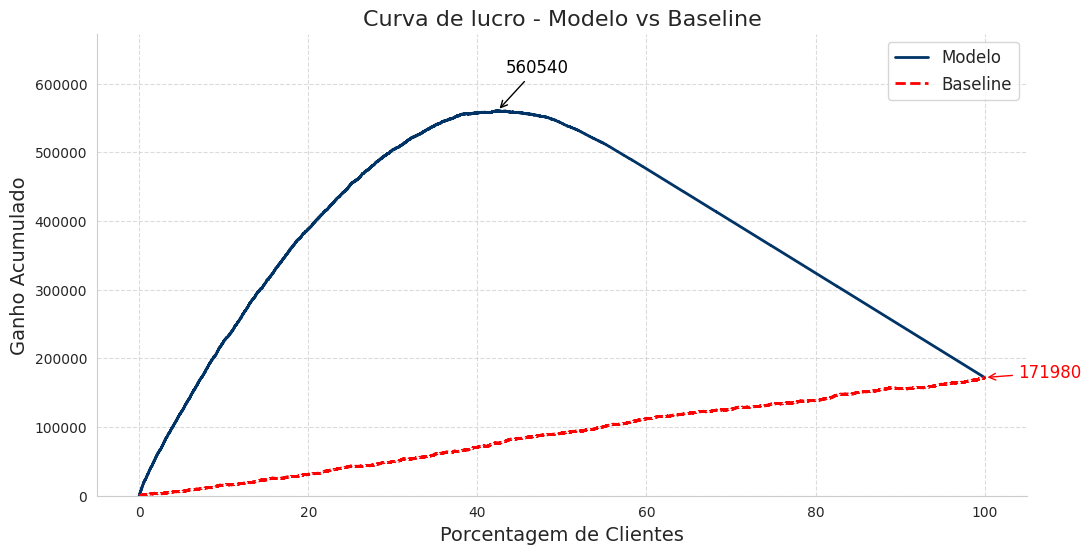

In [112]:


df_lift = pd.DataFrame({
    'proba': yproba_rf[:,1],
    'real' : y_test
})
df_lift = df_lift.sort_values('proba', ascending=False)

ganho = {1: 90,
        0: -10}
df_lift['ganho'] = df_lift['real'].map(ganho)
df_lift['ganho_acumulado'] = df_lift['ganho'].cumsum()
df_lift['porcentagem_de_clientes'] = np.arange(1, len(df_lift) + 1) / len(df_lift) * 100

df_lift_baseline = pd.DataFrame({'baseline': [1] * len(y_test), 'real': y_test})
df_lift_baseline['ganho'] = df_lift_baseline['real'].map(ganho)
df_lift_baseline['ganho_acumulado'] = df_lift_baseline['ganho'].cumsum()
df_lift_baseline['porcentagem_de_clientes'] = np.arange(1, len(df_lift_baseline) + 1) / len(df_lift_baseline) * 100

plt.figure(figsize=(12,6))

sns.lineplot(x='porcentagem_de_clientes', y='ganho_acumulado', data=df_lift, label='Modelo', linewidth=2)
sns.lineplot(x='porcentagem_de_clientes', y='ganho_acumulado', data=df_lift_baseline, label='Baseline', color='red', linestyle='--', linewidth=2)

# Pegando os pontos de maior ganho
df_lift_max = df_lift.loc[df_lift['ganho_acumulado'].idxmax()]
df_lift_baseline_max = df_lift_baseline.iloc[-1]  

# Ajuste do eixo Y considerando o menor valor do baseline
y_min = min(df_lift_baseline['ganho_acumulado'].min(), 0) 
plt.ylim(y_min * 1.2, df_lift['ganho_acumulado'].max() * 1.2)

# Anotação do maior lucro do modelo
plt.annotate(f'{df_lift_max["ganho_acumulado"]:.0f}',
             xy=(df_lift_max['porcentagem_de_clientes'], df_lift_max['ganho_acumulado']),
             xytext=(df_lift_max['porcentagem_de_clientes'] + 1, df_lift_max['ganho_acumulado'] * 1.1),
             arrowprops=dict(arrowstyle="->", color='black'),
             fontsize=12, color='black')

# Anotação do baseline no final da curva (100% dos clientes)
plt.annotate(f'{df_lift_baseline_max["ganho_acumulado"]:.0f}',
             xy=(df_lift_baseline_max['porcentagem_de_clientes'], df_lift_baseline_max['ganho_acumulado']),
             xytext=(df_lift_baseline_max['porcentagem_de_clientes'] + 4, df_lift_baseline_max['ganho_acumulado'] ),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=12, color='red')

# Melhorias na formatação
plt.xlabel('Porcentagem de Clientes', fontsize=14)
plt.ylabel('Ganho Acumulado', fontsize=14)
plt.title('Curva de lucro - Modelo vs Baseline', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustando os eixos
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



In [60]:

size_sample = 20000
ganho_cliente = 100
custo_ligacao = 10

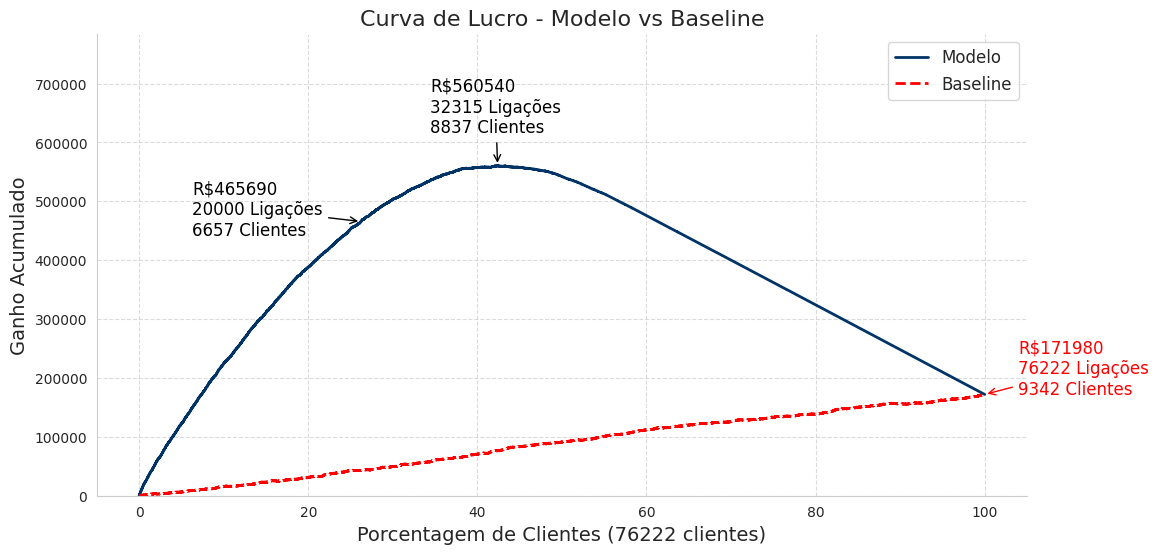

In [114]:

df_lift = pd.DataFrame({
    'proba': yproba_rf[:,1],
    'real' : y_test
})
df_lift = df_lift.sort_values('proba', ascending=False).reset_index(drop=True)

ganho = {1: ganho_cliente - custo_ligacao,
        0: -custo_ligacao}

# df_lift = df_lift.iloc[0:20000,:]

df_lift['ganho'] = df_lift['real'].map(ganho)
df_lift['ganho_acumulado'] = df_lift['ganho'].cumsum()
df_lift['clientes_capturados'] = df_lift['real'].cumsum()
df_lift['porcentagem_de_clientes'] = np.arange(1, len(df_lift) + 1) / len(df_lift) * 100

df_lift_baseline = pd.DataFrame({'baseline': [1] * len(y_test),
                                'real': y_test})

df_lift_baseline['ganho'] = df_lift_baseline['real'].map(ganho)
df_lift_baseline['ganho_acumulado'] = df_lift_baseline['ganho'].cumsum()
df_lift_baseline['clientes_capturados'] = df_lift_baseline['real'].cumsum()
df_lift_baseline['porcentagem_de_clientes'] = np.arange(1, len(df_lift_baseline) + 1) / len(df_lift_baseline) * 100

plt.figure(figsize=(12,6))

sns.lineplot(x='porcentagem_de_clientes', y='ganho_acumulado', data=df_lift, label='Modelo', linewidth=2)
sns.lineplot(x='porcentagem_de_clientes', y='ganho_acumulado', data=df_lift_baseline, label='Baseline', color='red', linestyle='--', linewidth=2)

# Pegando os pontos de maior ganho
df_lift_max = df_lift.loc[df_lift['ganho_acumulado'].idxmax()]
df_lift_baseline_max = df_lift_baseline.iloc[-1]  
df_lift_sample = df_lift.iloc[size_sample]

# Ajuste do eixo Y considerando o menor valor do baseline
y_min = min(df_lift_baseline['ganho_acumulado'].min(), 0) 
plt.ylim(y_min * 1.3, df_lift['ganho_acumulado'].max() * 1.4)

# Anotação do maior lucro do modelo
plt.annotate(f'R${df_lift_max["ganho_acumulado"]:.0f}\n{df_lift_max.name} Ligações\n{df_lift_max["clientes_capturados"]:.0f} Clientes',
             xy=(df_lift_max['porcentagem_de_clientes'], df_lift_max['ganho_acumulado']),
            xytext=(df_lift_max['porcentagem_de_clientes'] - 8 , df_lift_max['ganho_acumulado'] *1.1 ),
             arrowprops=dict(arrowstyle="->", color='black'),
             fontsize=12, color='black')

# Anotação do baseline no final da curva (100% dos clientes)
plt.annotate(f'R${df_lift_baseline_max["ganho_acumulado"]:.0f}\n{len(df_lift)} Ligações\n{df_lift_baseline_max["clientes_capturados"]:.0f} Clientes',
             xy=(df_lift_baseline_max['porcentagem_de_clientes'], df_lift_baseline_max['ganho_acumulado']),
             xytext=(df_lift_baseline_max['porcentagem_de_clientes'] + 4, df_lift_baseline_max['ganho_acumulado'] ),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=12, color='red')

# Anotação do lucro e captação de clientes ao fazer 20000 ligações
plt.annotate(f'R${df_lift_sample["ganho_acumulado"]:.0f}\n{size_sample} Ligações\n{df_lift_sample["clientes_capturados"]:.0f} Clientes',
             xy=(df_lift_sample['porcentagem_de_clientes'], df_lift_sample['ganho_acumulado']),
            xytext=(df_lift_sample['porcentagem_de_clientes'] -20 , df_lift_sample['ganho_acumulado']*0.95),
             arrowprops=dict(arrowstyle="->", color='black'),
             fontsize=12, color='black')

# Melhorias na formatação
plt.xlabel(f'Porcentagem de Clientes ({len(df_lift)} clientes)', fontsize=14)
plt.ylabel('Ganho Acumulado', fontsize=14)
plt.title('Curva de Lucro - Modelo vs Baseline', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustando os eixos
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('../img/curva_lucro.png')

# 8.0 Deploy to production

In [62]:
data_test = pd.read_csv('../data/test.csv')
data_test.head(2)

with open("../src/models/rf.pkl", "rb") as f:
    modelo = pickle.load(f)

with open("../src/features/encoders.pkl", "rb") as f:
    final_encoders = pickle.load(f)

## 8.1 Class PropensityScore

In [63]:
class PropensityScore():

    def __init__(self, data ):
        self.data = data
        self.encoders = pickle.load(open("../src/features/encoders.pkl", "rb"))

    def visualize(self):
        return self.data
    
    def rename_cols(self):
        df = self.data
        cols = list(df.columns)
        lista = [inflection.underscore(coluna) for coluna in cols ]
        df.columns = lista
        self.data = df
        return df


    def transform(self):
        ss, mms_age,mms_vintage, mms_damage, target_policy_sales, target_vehicle_damage, frequency_region_code, damage_region = self.encoders

        df = self.data.copy()
        df['pct_damage_region'] = df['region_code'].map(damage_region)

        df['annual_premium'] = ss.transform(df[['annual_premium']])
        
        df['age'] = mms_age.transform(df[['age']].values)
        df['pct_damage_region'] = mms_damage.transform(df[['pct_damage_region']])
        df['pct_damage_region'] = df['pct_damage_region'].fillna(0)

        df['policy_sales_channel'] = df['policy_sales_channel'].map(target_policy_sales)
        df['vehicle_damage'] = df['vehicle_damage'].map(target_vehicle_damage)
        df['region_code'] = df['region_code'].map(frequency_region_code)
        
        df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 0 if x == '< 1 Year'
                                                        else 1 if x == '1-2 Year'
                                                        else 2 if x == '> 2 Years' else x)

        df.set_index('id', inplace=True)
        df = df[['age', 'region_code', 'previously_insured', 'vehicle_age',
                'vehicle_damage', 'annual_premium', 'policy_sales_channel','pct_damage_region']]
        
        self.data = df  
        return df
        

    def predict(self, model):
        """ Retorna o dataframe com as probabilidades. """
        df = self.data.copy()
        df['score'] = model.predict_proba(self.data)[:,1]
        df = df.reset_index()


        return df.to_json(orient = 'records', date_format='iso') 


In [64]:
ps = PropensityScore(data_test.sample(2))

model = pickle.load(open("../src/models/rf.pkl", "rb"))


ps.rename_cols()
ps.transform()
predict = ps.predict(model)
pd.DataFrame(json.loads(predict))[['id', 'score']]

,id,score
0,463505,0.037402
1,505675,0.366979


## 8.2 API Handler

In [ ]:
import os
import json
import pickle
import pandas as pd
from flask import Flask, request, Response

# loading model 
model = pickle.load(open('../src/models/rf.pkl', 'rb'))

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    test_json = request.get_json()


    if test_json: # there is data
        if isinstance(test_json, dict):  # unique instance
            raw_data = pd.DataFrame(test_json, index=[0])

        else: 
            raw_data = pd.DataFrame(test_json, columns=test_json[0].keys())

        pipeline = PropensityScore(raw_data)
        pipeline.rename_cols()
        pipeline.transform()
        predict = pipeline.predict(model)
        
        return predict

    else: 
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://192.168.1.162:5001
Press CTRL+C to quit


In [68]:
import requests

# Definindo a URL
# url = "http://127.0.0.1:5000/predict"
url = "https://propensao-compra-1xtv.onrender.com/predict"

data = data_test.sample(10).to_dict(orient='records') 

headers = {"Content-Type": "application/json"}

response = requests.post(url, json=data, headers=headers)

print(response.status_code)  
print(response.json()) 


dicionario = response.json()
prediction = json.loads(dicionario["prediction"])
df = pd.DataFrame(prediction)
df


200
{'prediction': '[{"id":497436,"age":0.0615384615,"region_code":0.0241114514,"previously_insured":1,"vehicle_age":0,"vehicle_damage":0.0053669186,"annual_premium":-0.6546665124,"policy_sales_channel":0.0286174416,"pct_damage_region":0.1891891892,"score":0.0002252013},{"id":412289,"age":0.3692307692,"region_code":0.0892013005,"previously_insured":0,"vehicle_age":1,"vehicle_damage":0.2377970939,"annual_premium":0.2049536914,"policy_sales_channel":0.2686910513,"pct_damage_region":0.4864864865,"score":0.3337168486},{"id":451793,"age":0.5538461538,"region_code":0.278587506,"previously_insured":0,"vehicle_age":1,"vehicle_damage":0.2377970939,"annual_premium":0.0166343837,"policy_sales_channel":0.1239669421,"pct_damage_region":1.0,"score":0.206811398},{"id":449687,"age":0.5538461538,"region_code":0.278587506,"previously_insured":0,"vehicle_age":1,"vehicle_damage":0.2377970939,"annual_premium":-1.6212678631,"policy_sales_channel":0.190007602,"pct_damage_region":1.0,"score":0.2482276036},{"i

,id,age,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,pct_damage_region,score
0,497436,0.061538,0.024111,1,0,0.005367,-0.654667,0.028617,0.189189,0.000225
1,412289,0.369231,0.089201,0,1,0.237797,0.204954,0.268691,0.486486,0.333717
2,451793,0.553846,0.278588,0,1,0.237797,0.016634,0.123967,1.000000,0.206811
3,449687,0.553846,0.278588,0,1,0.237797,-1.621268,0.190008,1.000000,0.248228
4,427376,0.507692,0.032168,0,1,0.237797,-1.621268,0.190008,0.081081,0.292234
5,418203,0.353846,0.278588,0,1,0.005367,0.784009,0.198907,1.000000,0.026604
6,439600,0.676923,0.052093,0,1,0.237797,0.231235,0.190008,0.432432,0.192187
7,507105,0.092308,0.089201,0,0,0.237797,0.066180,0.028617,0.486486,0.078752
8,410666,0.353846,0.278588,1,1,0.005367,0.317794,0.190008,1.000000,0.001285
9,501716,0.569231,0.001578,0,1,0.237797,-0.113727,0.190008,0.648649,0.235810


In [134]:
response

<Response [500]>